# Importing

In [15]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn_som.som import SOM
import salishsea_tools.viz_tools as sa_vi


# Datasets Preparation

In [16]:
def datasets_preparation():
    
    ds = xr.open_dataset ('/results2/SalishSea/nowcast-green.202111/31mar22/SalishSea_1d_20220331_20220331_grid_T.nc')
    ds_bio = xr. open_dataset ('/results2/SalishSea/nowcast-green.202111/31mar22/SalishSea_1d_20220331_20220331_biol_T.nc')

    # Variable selection
    temp = ds.votemper
    saline = ds.vosaline
    date = pd.DatetimeIndex(ds['time_counter'].values)

    # Biological variables
    sil = ds_bio.silicon
    flag = ds_bio.flagellates
    diat = ds_bio.diatoms

    # Open the mesh mask
    mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
    mask = mesh.tmask.to_numpy()
    
    return (ds, temp, saline, date, mask, sil, flag, diat)


# Masking

In [17]:
def masking (depth, temp, saline, mask, sil, flag, diat):

    temp = temp.where(mask[0,depth]==1)
    saline = saline.where(mask[0,depth]==1)

    sil = sil.where(mask[0,depth]==1)
    flag = flag.where(mask[0,depth]==1)
    diat = diat.where(mask[0,depth]==1)

    return (temp, saline, sil, flag, diat)

# SOM

In [18]:
def som (depth, temp, saline):
    
    # Post processing 
    inputs = np.stack((temp[0,depth].values.flatten(), saline[0,depth].values.flatten()))
    indx = np.argwhere(~np.isnan(inputs[0]) & ~np.isnan(inputs[1])) 
    inputs2 = np.transpose(inputs)  
    inputs2 = inputs2[indx[:,0]]

    # SOM
    temp_som = SOM(m=2, n=3, dim= inputs2[0,:].size)
    temp_som.fit(inputs2)
    predictions = temp_som.predict(inputs2)

    # Post processing
    unique, counts = np.unique(predictions, return_counts=True)
    indx2 = np.full(inputs[0,:].size,np.nan)
    indx2[indx[:,0]] = predictions
    clusters = np.reshape(indx2,(898,398))   

    return (unique, counts, inputs2, predictions, clusters)


# Printing

In [19]:
def printing (inputs, predictions, unique, counts):

    # Preparation of the dataframe
    d = {'temperature': inputs[:,0], 'salinity': inputs[:,1], 'cluster': predictions}
    df = pd.DataFrame(d) 

    # Calculating the metrics
    mean_temp = np.round(df.groupby('cluster')['temperature'].mean(), 2)
    mean_sal = np.round(df.groupby('cluster')['salinity'].mean(), 2)
    min_temp = np.round(df.groupby('cluster')['temperature'].min(), 2)
    max_temp = np.round(df.groupby('cluster')['temperature'].max(), 2)
    min_sal = np.round(df.groupby('cluster')['salinity'].min(), 2)
    max_sal = np.round(df.groupby('cluster')['salinity'].max(), 2)

    # Printing
    for i in unique:
            print('The amount of grid boxes for cluster ' + str(i), 'is ' + str(counts[i]), '\n')

            print ('The minimum temperature for cluster '+ str(i), 'is ' + str(min_temp[i]), 'degrees Celsius')
            print ('The maximum temperature for cluster '+ str(i), 'is ' + str(max_temp[i]), 'degrees Celsius')
            print ('The mean temperature for cluster '+ str(i), 'is ' + str(mean_temp[i]), 'degrees Celsius', '\n')

            print ('The minimum salinity for cluster '+ str(i), 'is ' + str(min_sal[i]), 'g/kg')
            print ('The maximum salinity for cluster '+ str(i), 'is ' + str(max_sal[i]), 'g/kg')
            print ('The mean salinity for cluster '+ str(i), 'is ' + str(mean_sal[i]), 'g/kg', '\n'*2)
        

# Plotting

In [20]:
def plotting (depth, clusters, unique, sil, flag, diat):

    # Preparation of the dataarray 
    map = xr.DataArray(clusters,
                    coords = {'y': temp[0,depth].y, 'x': temp[0,depth].x},
                    dims = ['y','x'],
                    attrs=dict(description="Clusters of the performed self organizing map algorithm",
                                long_name ="Cluster",
                                units="count"),
                    ) 

    fig, ax = plt.subplots(2,2, figsize=(10, 15))

    cmap = plt.get_cmap('viridis', unique.max()+1)
    cmap.set_bad('gray')

    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.95, 
                    wspace=0.1, 
                    hspace=0.15)

    map.plot.pcolormesh(ax=ax[0,0], cmap=cmap, levels= np.concatenate((unique,[unique.size])), cbar_kwargs={'ticks': unique})
    
    cmap = plt.get_cmap('Accent')
    cmap.set_bad('gray')
    sil[0,depth].plot.pcolormesh(ax=ax[0,1], cmap=cmap) 
    flag[0,depth].plot.pcolormesh(ax=ax[1,0], cmap=cmap) 
    diat[0,depth].plot.pcolormesh(ax=ax[1,1], cmap=cmap) 

    sa_vi.set_aspect(ax[0,0])
    sa_vi.set_aspect(ax[0,1])
    sa_vi.set_aspect(ax[1,0])
    sa_vi.set_aspect(ax[1,1])

    ax[0,0].title.set_text('Clustering')
    ax[0,1].title.set_text('Silicones')
    ax[1,0].title.set_text('Flaggelates')
    ax[1,1].title.set_text('Diatoms')

    if date[0].month < 10:
        month = '0' + str(date[0].month)
    else:
        month = str(date[0].month)

    if date[0].day < 10:
        day = '0' + str(date[0].day)  
    else:
        day = str(date[0].day) 

    fig.suptitle('Depth: ' + str(np.round(ds['deptht'][depth].values,2)) + ' meters, ' + str(date[0].year) + '/' + month + '/' + day)
    plt.show()


# Main FOR Loop From Where All Functions are Called

The amount of grid boxes for cluster 0 is 8753 

The minimum temperature for cluster 0 is 7.28 degrees Celsius
The maximum temperature for cluster 0 is 10.58 degrees Celsius
The mean temperature for cluster 0 is 9.18 degrees Celsius 

The minimum salinity for cluster 0 is 22.08 g/kg
The maximum salinity for cluster 0 is 25.22 g/kg
The mean salinity for cluster 0 is 23.99 g/kg 


The amount of grid boxes for cluster 1 is 14055 

The minimum temperature for cluster 1 is 7.38 degrees Celsius
The maximum temperature for cluster 1 is 10.53 degrees Celsius
The mean temperature for cluster 1 is 9.03 degrees Celsius 

The minimum salinity for cluster 1 is 25.02 g/kg
The maximum salinity for cluster 1 is 27.75 g/kg
The mean salinity for cluster 1 is 26.15 g/kg 


The amount of grid boxes for cluster 2 is 14621 

The minimum temperature for cluster 2 is 7.34 degrees Celsius
The maximum temperature for cluster 2 is 10.01 degrees Celsius
The mean temperature for cluster 2 is 8.58 degrees Celsius 


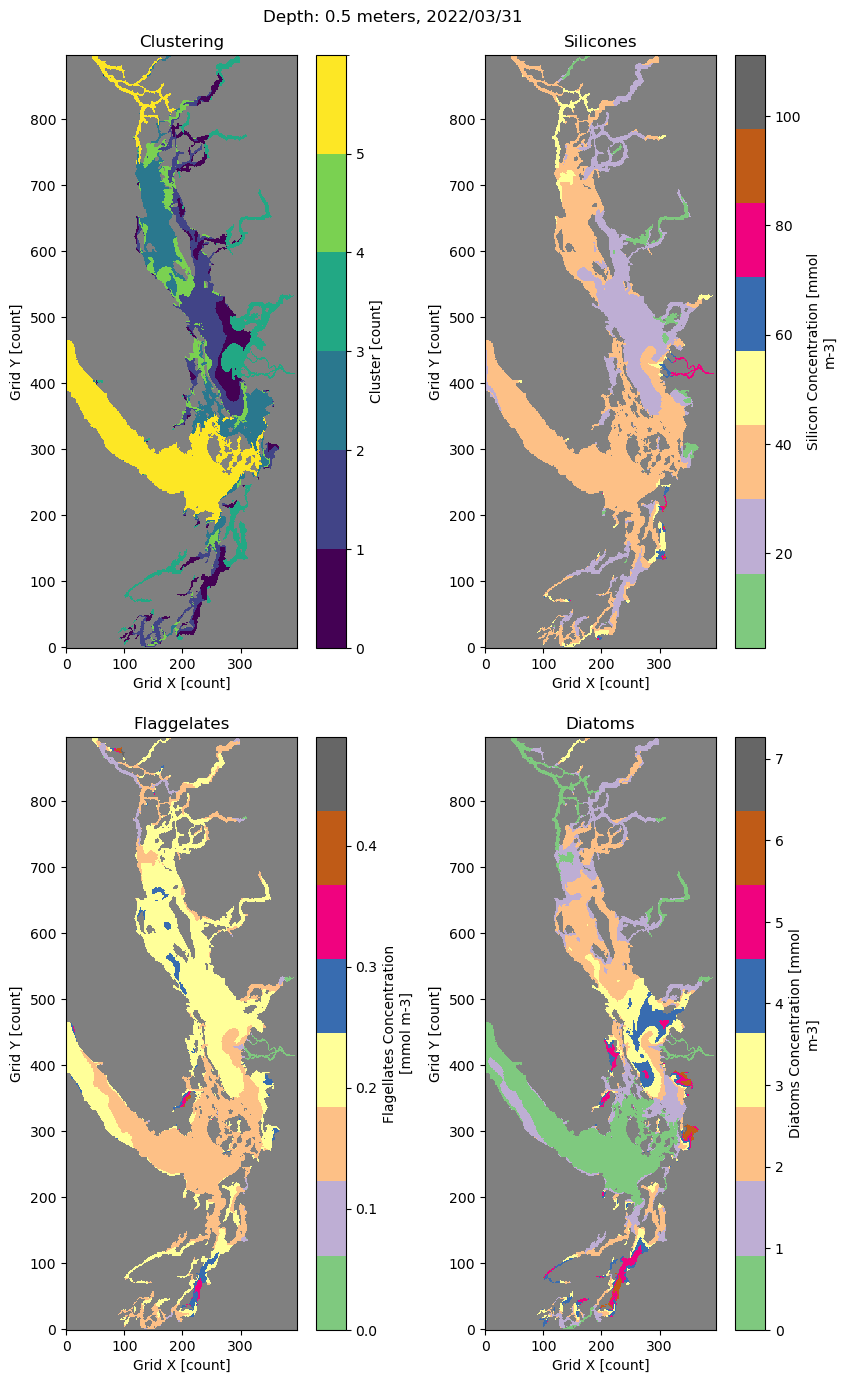

The amount of grid boxes for cluster 0 is 26540 

The minimum temperature for cluster 0 is 6.72 degrees Celsius
The maximum temperature for cluster 0 is 9.72 degrees Celsius
The mean temperature for cluster 0 is 7.99 degrees Celsius 

The minimum salinity for cluster 0 is 28.87 g/kg
The maximum salinity for cluster 0 is 31.32 g/kg
The mean salinity for cluster 0 is 30.36 g/kg 


The amount of grid boxes for cluster 1 is 12961 

The minimum temperature for cluster 1 is 7.42 degrees Celsius
The maximum temperature for cluster 1 is 10.0 degrees Celsius
The mean temperature for cluster 1 is 8.7 degrees Celsius 

The minimum salinity for cluster 1 is 26.57 g/kg
The maximum salinity for cluster 1 is 28.19 g/kg
The mean salinity for cluster 1 is 27.37 g/kg 


The amount of grid boxes for cluster 2 is 6117 

The minimum temperature for cluster 2 is 7.26 degrees Celsius
The maximum temperature for cluster 2 is 10.54 degrees Celsius
The mean temperature for cluster 2 is 9.11 degrees Celsius 

Th

The amount of grid boxes for cluster 0 is 6516 

The minimum temperature for cluster 0 is 7.67 degrees Celsius
The maximum temperature for cluster 0 is 10.67 degrees Celsius
The mean temperature for cluster 0 is 9.07 degrees Celsius 

The minimum salinity for cluster 0 is 23.06 g/kg
The maximum salinity for cluster 0 is 25.55 g/kg
The mean salinity for cluster 0 is 24.47 g/kg 


The amount of grid boxes for cluster 1 is 14611 

The minimum temperature for cluster 1 is 7.5 degrees Celsius
The maximum temperature for cluster 1 is 9.98 degrees Celsius
The mean temperature for cluster 1 is 8.55 degrees Celsius 

The minimum salinity for cluster 1 is 27.04 g/kg
The maximum salinity for cluster 1 is 28.46 g/kg
The mean salinity for cluster 1 is 27.8 g/kg 


The amount of grid boxes for cluster 2 is 26066 

The minimum temperature for cluster 2 is 6.73 degrees Celsius
The maximum temperature for cluster 2 is 9.68 degrees Celsius
The mean temperature for cluster 2 is 7.97 degrees Celsius 

The

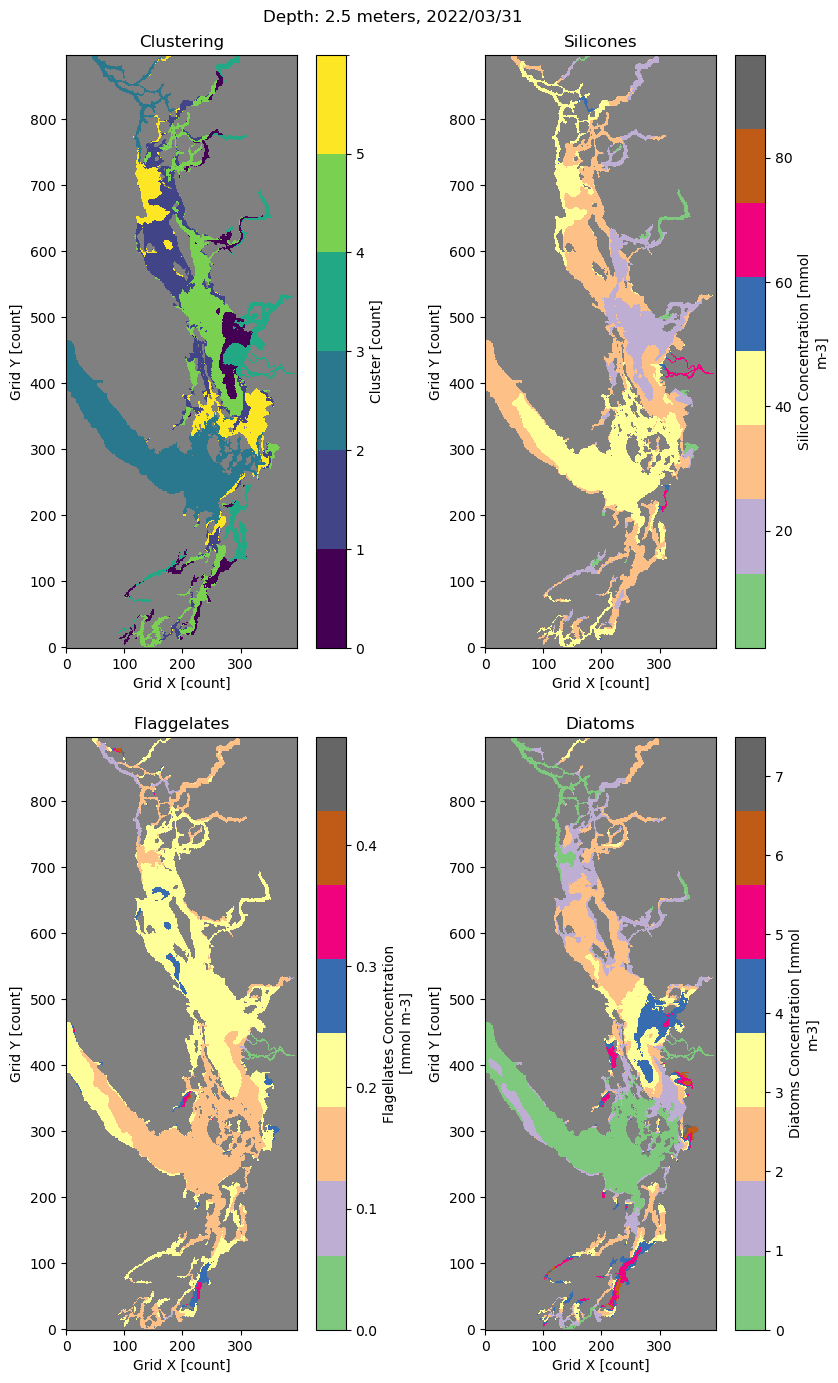

The amount of grid boxes for cluster 0 is 13277 

The minimum temperature for cluster 0 is 7.43 degrees Celsius
The maximum temperature for cluster 0 is 10.31 degrees Celsius
The mean temperature for cluster 0 is 8.76 degrees Celsius 

The minimum salinity for cluster 0 is 25.48 g/kg
The maximum salinity for cluster 0 is 27.13 g/kg
The mean salinity for cluster 0 is 26.43 g/kg 


The amount of grid boxes for cluster 1 is 13127 

The minimum temperature for cluster 1 is 7.45 degrees Celsius
The maximum temperature for cluster 1 is 10.17 degrees Celsius
The mean temperature for cluster 1 is 8.52 degrees Celsius 

The minimum salinity for cluster 1 is 26.85 g/kg
The maximum salinity for cluster 1 is 28.7 g/kg
The mean salinity for cluster 1 is 27.47 g/kg 


The amount of grid boxes for cluster 2 is 9209 

The minimum temperature for cluster 2 is 6.8 degrees Celsius
The maximum temperature for cluster 2 is 9.65 degrees Celsius
The mean temperature for cluster 2 is 8.27 degrees Celsius 

Th

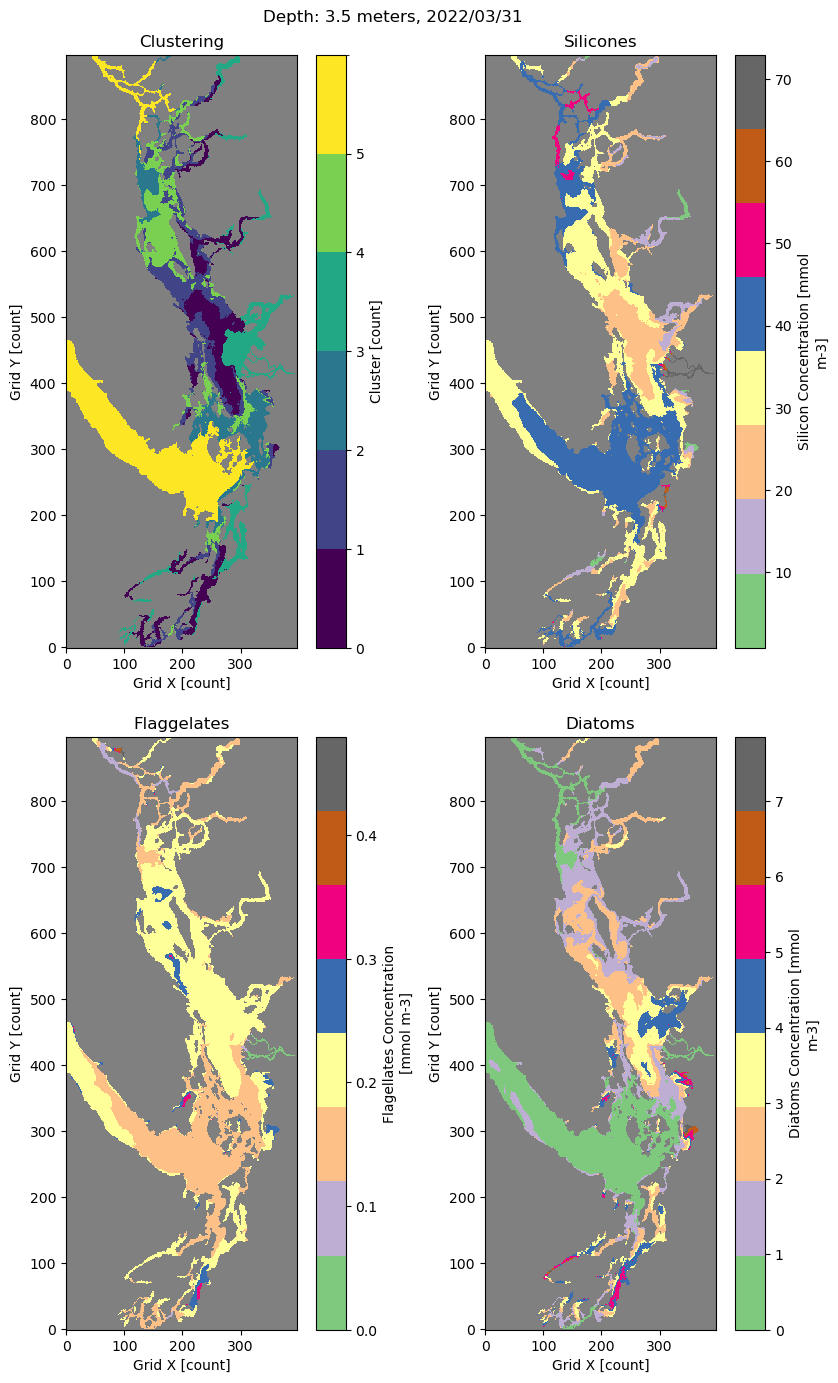

The amount of grid boxes for cluster 0 is 23075 

The minimum temperature for cluster 0 is 6.67 degrees Celsius
The maximum temperature for cluster 0 is 9.36 degrees Celsius
The mean temperature for cluster 0 is 7.93 degrees Celsius 

The minimum salinity for cluster 0 is 29.47 g/kg
The maximum salinity for cluster 0 is 31.36 g/kg
The mean salinity for cluster 0 is 30.55 g/kg 


The amount of grid boxes for cluster 1 is 11559 

The minimum temperature for cluster 1 is 7.41 degrees Celsius
The maximum temperature for cluster 1 is 9.52 degrees Celsius
The mean temperature for cluster 1 is 8.33 degrees Celsius 

The minimum salinity for cluster 1 is 28.17 g/kg
The maximum salinity for cluster 1 is 29.14 g/kg
The mean salinity for cluster 1 is 28.54 g/kg 


The amount of grid boxes for cluster 2 is 12690 

The minimum temperature for cluster 2 is 7.32 degrees Celsius
The maximum temperature for cluster 2 is 10.24 degrees Celsius
The mean temperature for cluster 2 is 8.59 degrees Celsius 



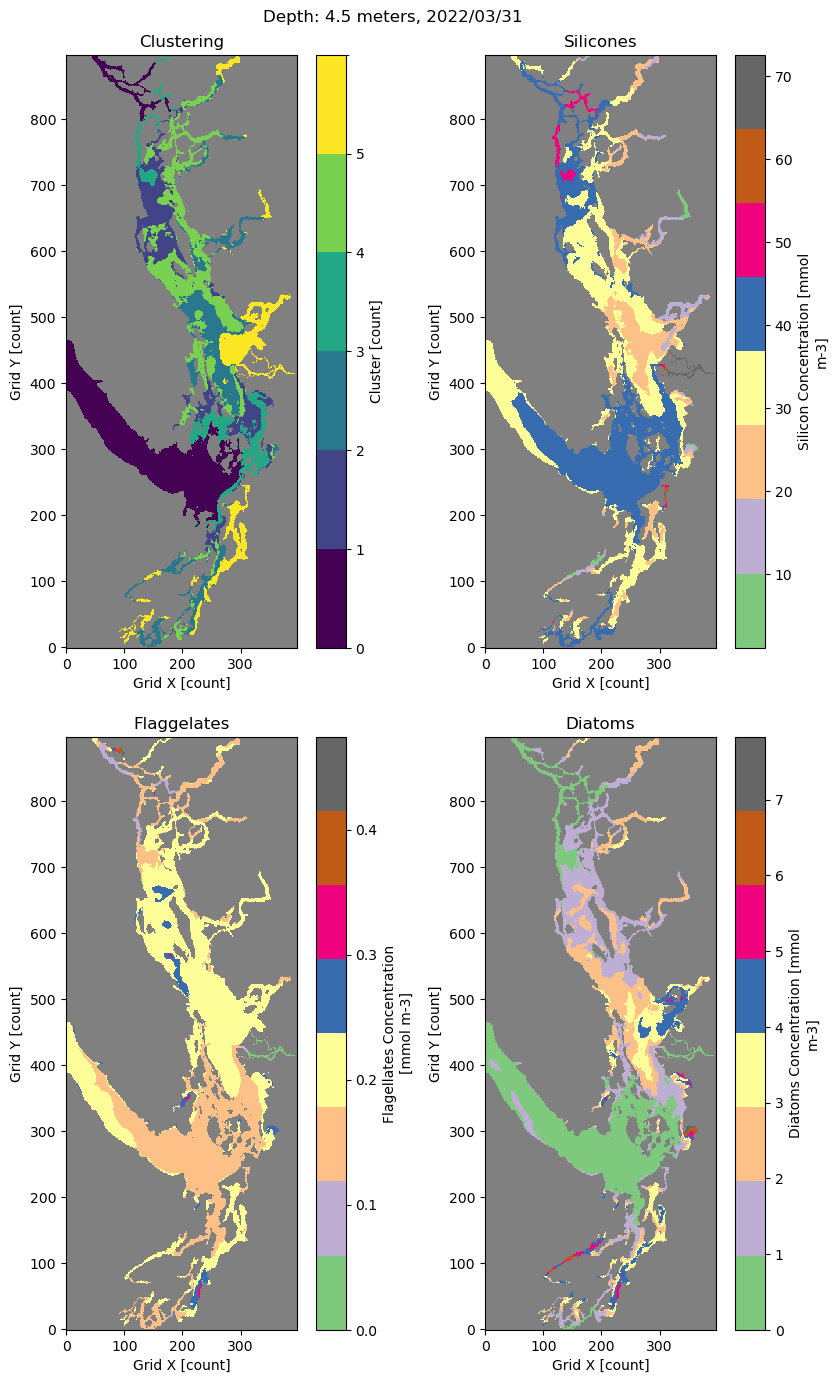

The amount of grid boxes for cluster 0 is 6773 

The minimum temperature for cluster 0 is 6.25 degrees Celsius
The maximum temperature for cluster 0 is 9.99 degrees Celsius
The mean temperature for cluster 0 is 8.52 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 26.64 g/kg
The mean salinity for cluster 0 is 23.39 g/kg 


The amount of grid boxes for cluster 1 is 14360 

The minimum temperature for cluster 1 is 7.42 degrees Celsius
The maximum temperature for cluster 1 is 10.33 degrees Celsius
The mean temperature for cluster 1 is 8.28 degrees Celsius 

The minimum salinity for cluster 1 is 27.5 g/kg
The maximum salinity for cluster 1 is 28.45 g/kg
The mean salinity for cluster 1 is 27.88 g/kg 


The amount of grid boxes for cluster 2 is 7397 

The minimum temperature for cluster 2 is 6.93 degrees Celsius
The maximum temperature for cluster 2 is 9.33 degrees Celsius
The mean temperature for cluster 2 is 8.23 degrees Celsius 

The m

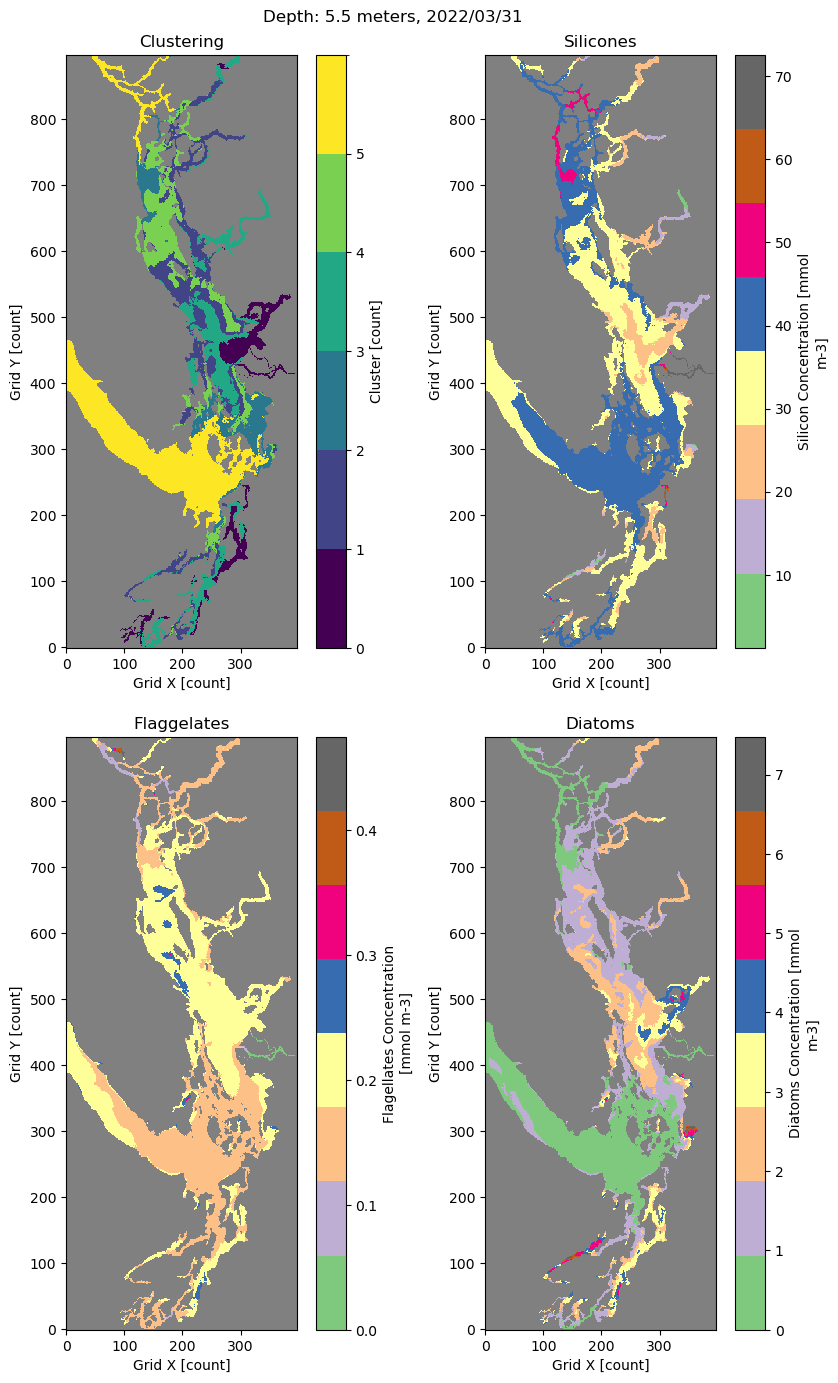

The amount of grid boxes for cluster 0 is 24798 

The minimum temperature for cluster 0 is 6.32 degrees Celsius
The maximum temperature for cluster 0 is 9.04 degrees Celsius
The mean temperature for cluster 0 is 7.92 degrees Celsius 

The minimum salinity for cluster 0 is 29.3 g/kg
The maximum salinity for cluster 0 is 31.42 g/kg
The mean salinity for cluster 0 is 30.49 g/kg 


The amount of grid boxes for cluster 1 is 13918 

The minimum temperature for cluster 1 is 7.42 degrees Celsius
The maximum temperature for cluster 1 is 10.19 degrees Celsius
The mean temperature for cluster 1 is 8.13 degrees Celsius 

The minimum salinity for cluster 1 is 28.16 g/kg
The maximum salinity for cluster 1 is 28.86 g/kg
The mean salinity for cluster 1 is 28.49 g/kg 


The amount of grid boxes for cluster 2 is 822 

The minimum temperature for cluster 2 is 6.25 degrees Celsius
The maximum temperature for cluster 2 is 9.23 degrees Celsius
The mean temperature for cluster 2 is 7.43 degrees Celsius 

The

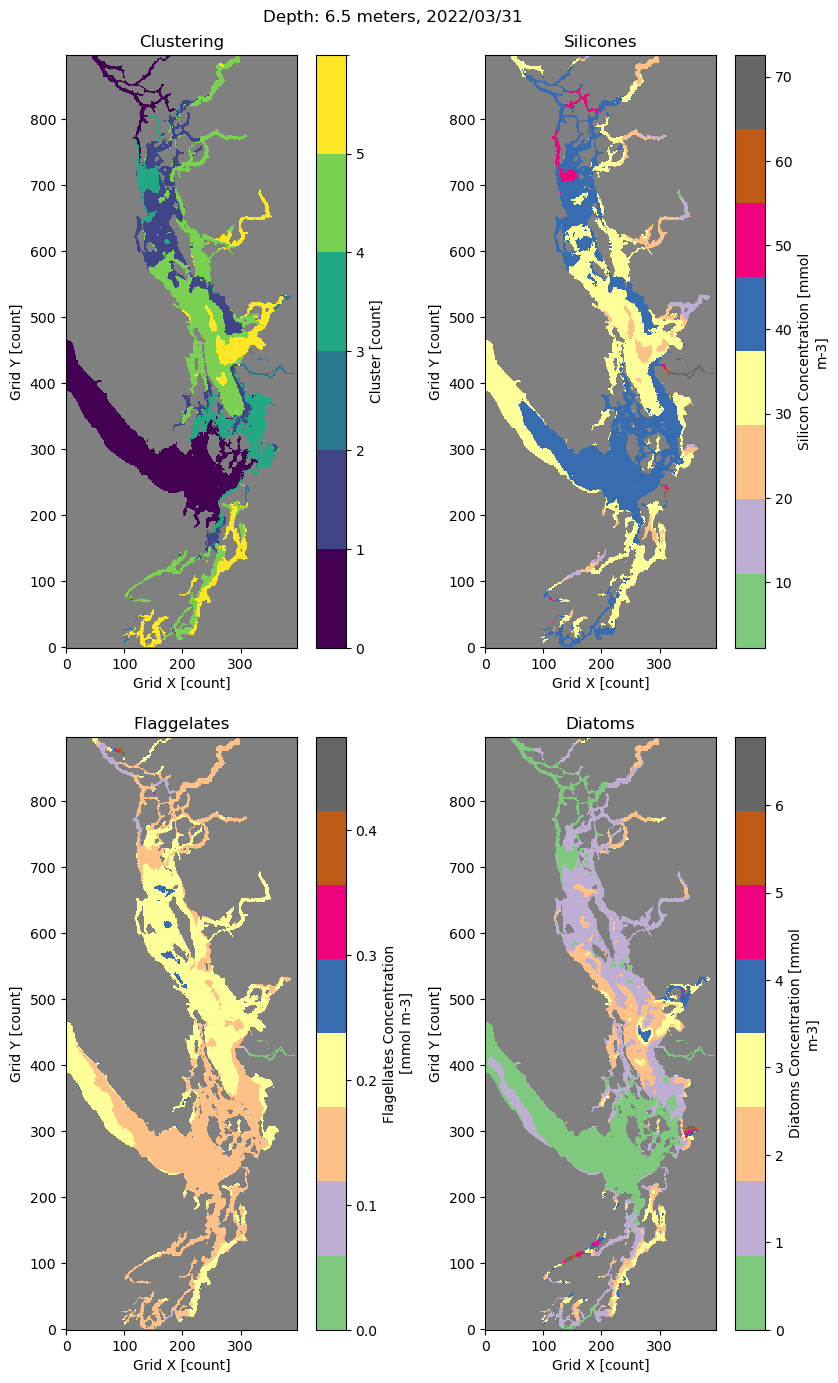

The amount of grid boxes for cluster 0 is 12029 

The minimum temperature for cluster 0 is 7.67 degrees Celsius
The maximum temperature for cluster 0 is 10.3 degrees Celsius
The mean temperature for cluster 0 is 8.56 degrees Celsius 

The minimum salinity for cluster 0 is 27.28 g/kg
The maximum salinity for cluster 0 is 28.84 g/kg
The mean salinity for cluster 0 is 27.83 g/kg 


The amount of grid boxes for cluster 1 is 11769 

The minimum temperature for cluster 1 is 7.67 degrees Celsius
The maximum temperature for cluster 1 is 10.19 degrees Celsius
The mean temperature for cluster 1 is 8.2 degrees Celsius 

The minimum salinity for cluster 1 is 28.5 g/kg
The maximum salinity for cluster 1 is 29.32 g/kg
The mean salinity for cluster 1 is 28.81 g/kg 


The amount of grid boxes for cluster 2 is 22427 

The minimum temperature for cluster 2 is 6.64 degrees Celsius
The maximum temperature for cluster 2 is 9.03 degrees Celsius
The mean temperature for cluster 2 is 7.9 degrees Celsius 

The

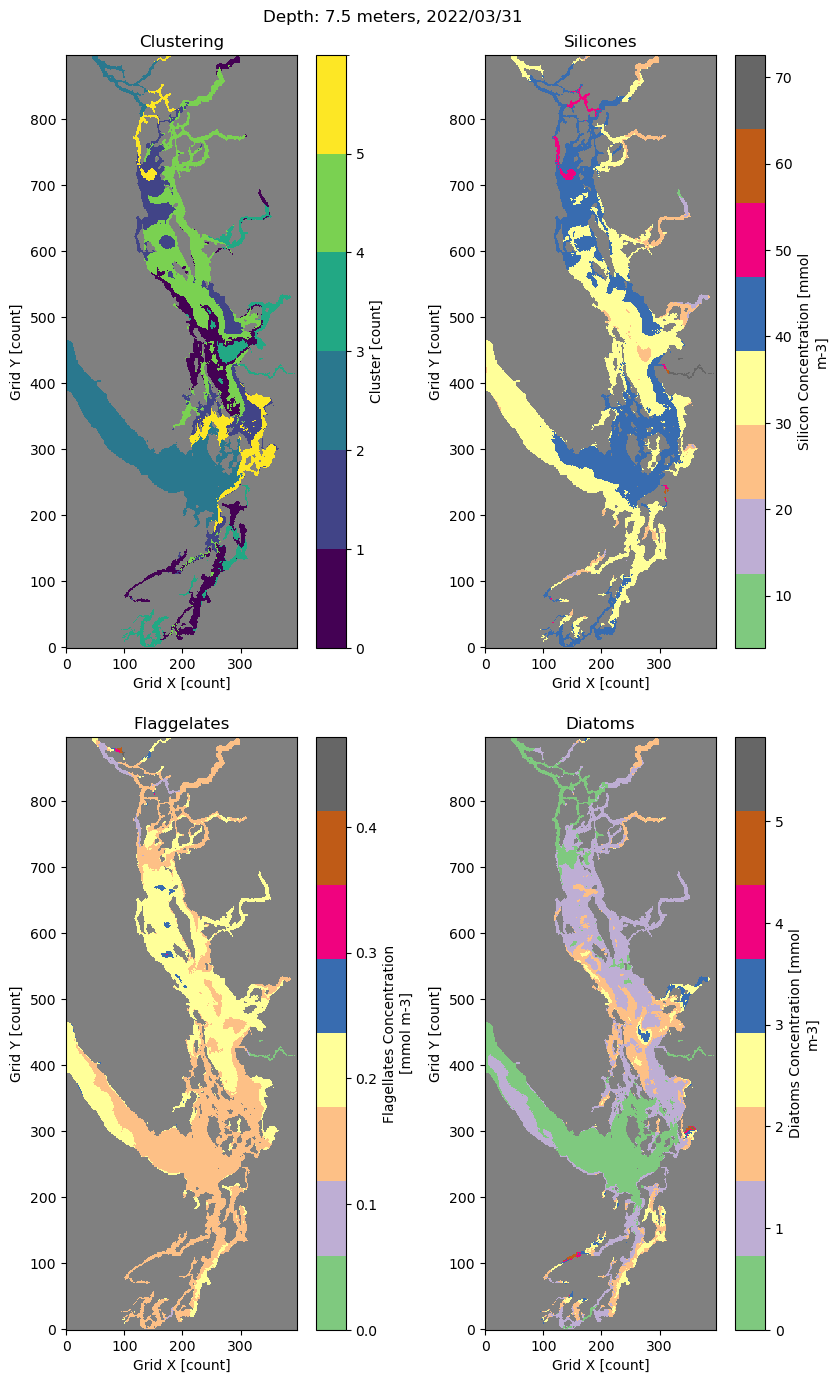

The amount of grid boxes for cluster 0 is 22608 

The minimum temperature for cluster 0 is 6.3 degrees Celsius
The maximum temperature for cluster 0 is 8.75 degrees Celsius
The mean temperature for cluster 0 is 7.89 degrees Celsius 

The minimum salinity for cluster 0 is 29.54 g/kg
The maximum salinity for cluster 0 is 31.46 g/kg
The mean salinity for cluster 0 is 30.6 g/kg 


The amount of grid boxes for cluster 1 is 9078 

The minimum temperature for cluster 1 is 7.82 degrees Celsius
The maximum temperature for cluster 1 is 10.19 degrees Celsius
The mean temperature for cluster 1 is 8.23 degrees Celsius 

The minimum salinity for cluster 1 is 28.65 g/kg
The maximum salinity for cluster 1 is 29.39 g/kg
The mean salinity for cluster 1 is 28.96 g/kg 


The amount of grid boxes for cluster 2 is 16497 

The minimum temperature for cluster 2 is 7.4 degrees Celsius
The maximum temperature for cluster 2 is 10.27 degrees Celsius
The mean temperature for cluster 2 is 8.35 degrees Celsius 

The

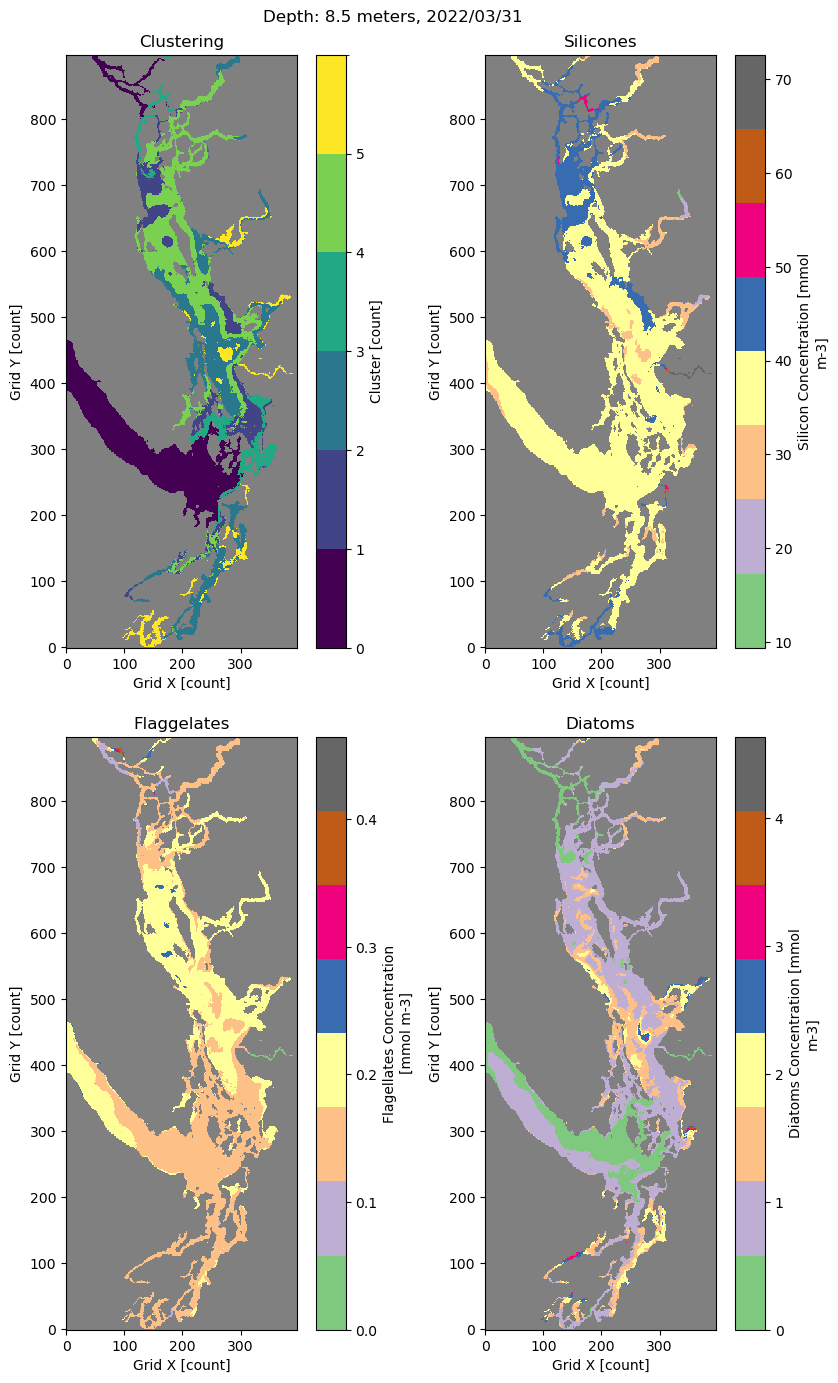

The amount of grid boxes for cluster 0 is 15443 

The minimum temperature for cluster 0 is 7.39 degrees Celsius
The maximum temperature for cluster 0 is 10.27 degrees Celsius
The mean temperature for cluster 0 is 8.29 degrees Celsius 

The minimum salinity for cluster 0 is 27.28 g/kg
The maximum salinity for cluster 0 is 28.52 g/kg
The mean salinity for cluster 0 is 28.02 g/kg 


The amount of grid boxes for cluster 1 is 19972 

The minimum temperature for cluster 1 is 7.49 degrees Celsius
The maximum temperature for cluster 1 is 10.25 degrees Celsius
The mean temperature for cluster 1 is 8.16 degrees Celsius 

The minimum salinity for cluster 1 is 28.23 g/kg
The maximum salinity for cluster 1 is 29.16 g/kg
The mean salinity for cluster 1 is 28.56 g/kg 


The amount of grid boxes for cluster 2 is 6664 

The minimum temperature for cluster 2 is 7.57 degrees Celsius
The maximum temperature for cluster 2 is 8.84 degrees Celsius
The mean temperature for cluster 2 is 8.1 degrees Celsius 

T

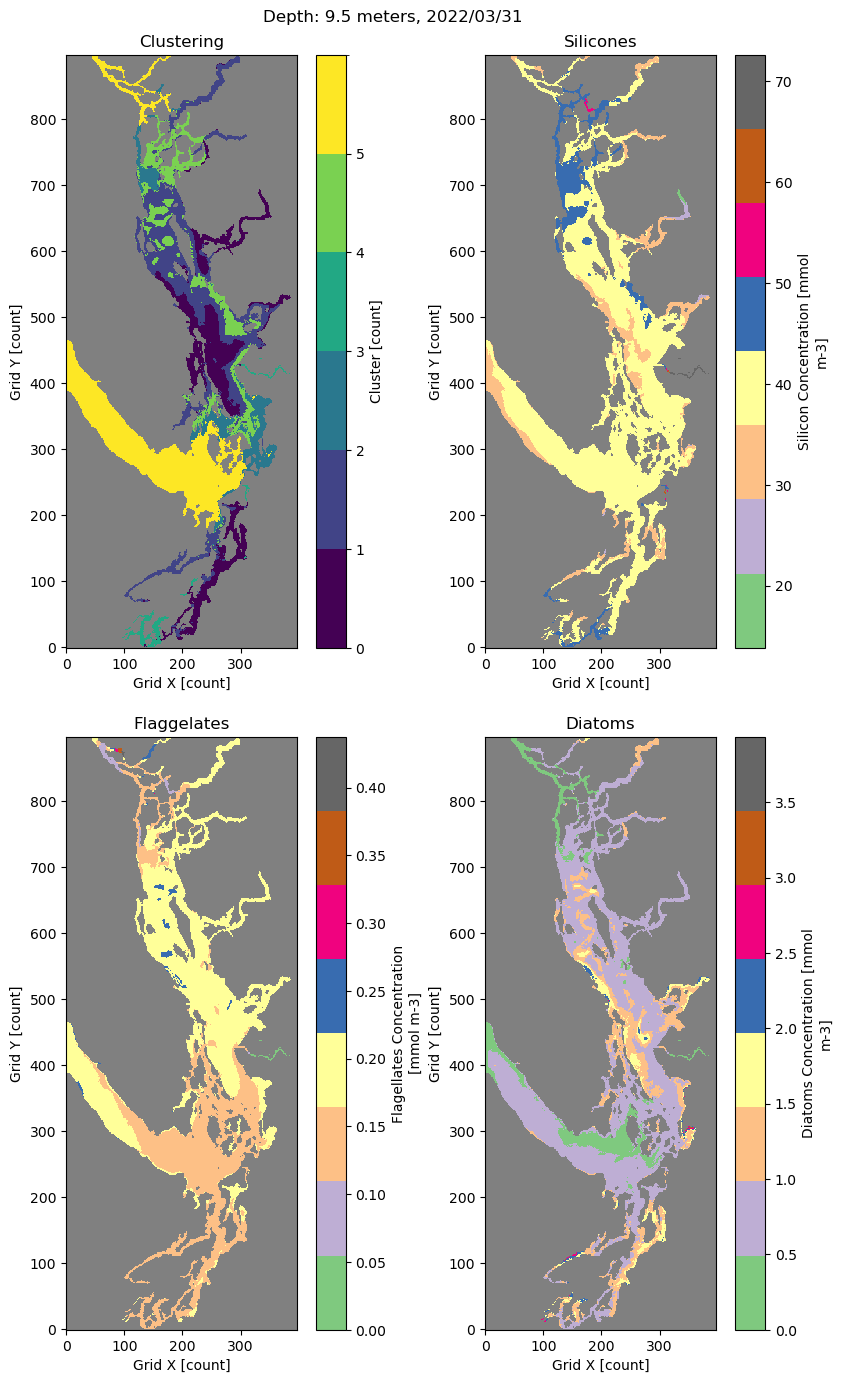

The amount of grid boxes for cluster 0 is 16795 

The minimum temperature for cluster 0 is 7.32 degrees Celsius
The maximum temperature for cluster 0 is 8.33 degrees Celsius
The mean temperature for cluster 0 is 7.86 degrees Celsius 

The minimum salinity for cluster 0 is 30.22 g/kg
The maximum salinity for cluster 0 is 31.56 g/kg
The mean salinity for cluster 0 is 30.84 g/kg 


The amount of grid boxes for cluster 1 is 6195 

The minimum temperature for cluster 1 is 7.55 degrees Celsius
The maximum temperature for cluster 1 is 8.77 degrees Celsius
The mean temperature for cluster 1 is 8.06 degrees Celsius 

The minimum salinity for cluster 1 is 29.18 g/kg
The maximum salinity for cluster 1 is 29.76 g/kg
The mean salinity for cluster 1 is 29.45 g/kg 


The amount of grid boxes for cluster 2 is 14106 

The minimum temperature for cluster 2 is 6.38 degrees Celsius
The maximum temperature for cluster 2 is 10.34 degrees Celsius
The mean temperature for cluster 2 is 8.58 degrees Celsius 

T

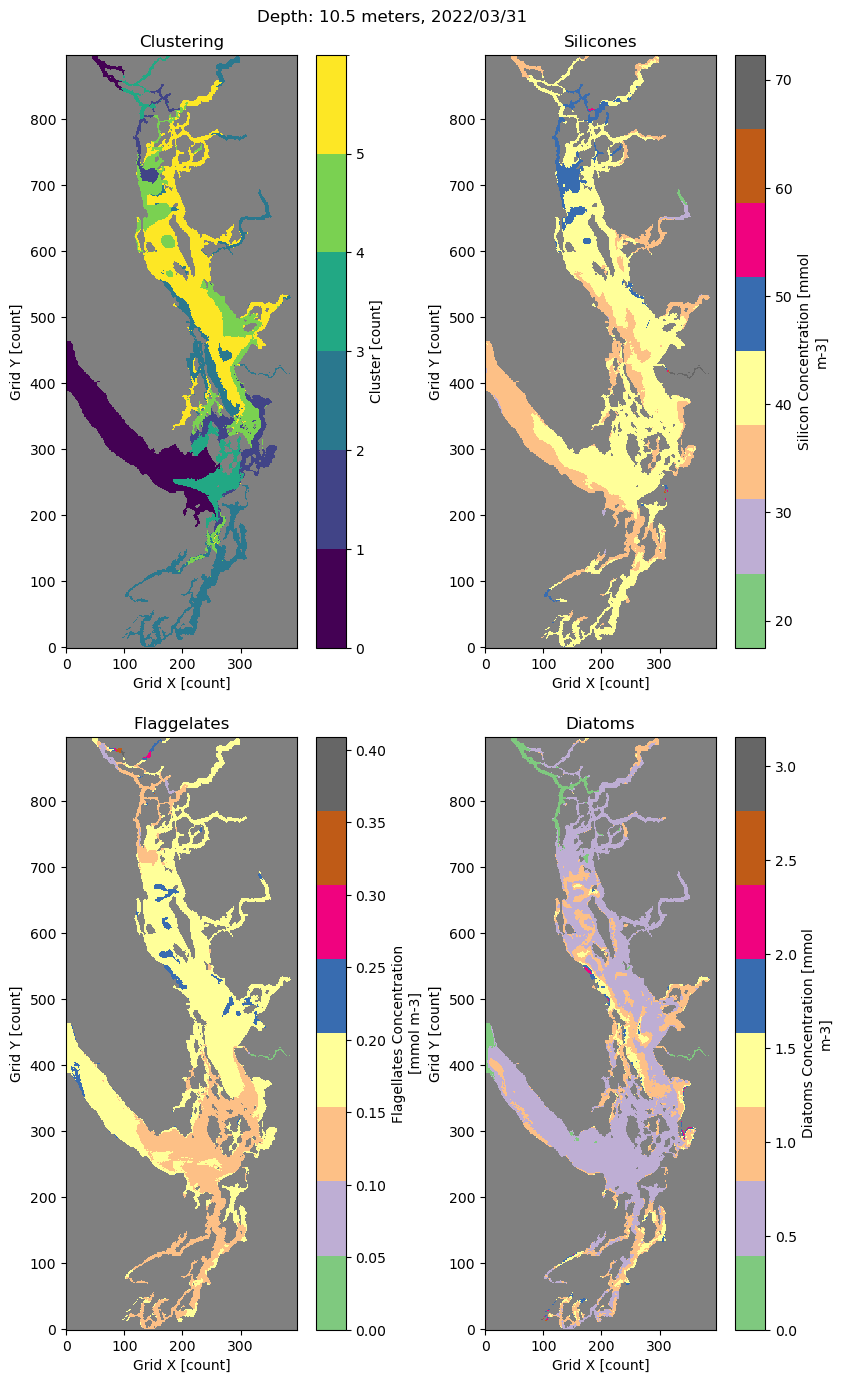

The amount of grid boxes for cluster 0 is 9932 

The minimum temperature for cluster 0 is 8.11 degrees Celsius
The maximum temperature for cluster 0 is 10.43 degrees Celsius
The mean temperature for cluster 0 is 8.73 degrees Celsius 

The minimum salinity for cluster 0 is 26.45 g/kg
The maximum salinity for cluster 0 is 29.33 g/kg
The mean salinity for cluster 0 is 28.46 g/kg 


The amount of grid boxes for cluster 1 is 6266 

The minimum temperature for cluster 1 is 7.55 degrees Celsius
The maximum temperature for cluster 1 is 8.67 degrees Celsius
The mean temperature for cluster 1 is 8.1 degrees Celsius 

The minimum salinity for cluster 1 is 29.11 g/kg
The maximum salinity for cluster 1 is 29.76 g/kg
The mean salinity for cluster 1 is 29.36 g/kg 


The amount of grid boxes for cluster 2 is 18069 

The minimum temperature for cluster 2 is 7.28 degrees Celsius
The maximum temperature for cluster 2 is 8.33 degrees Celsius
The mean temperature for cluster 2 is 7.85 degrees Celsius 

The

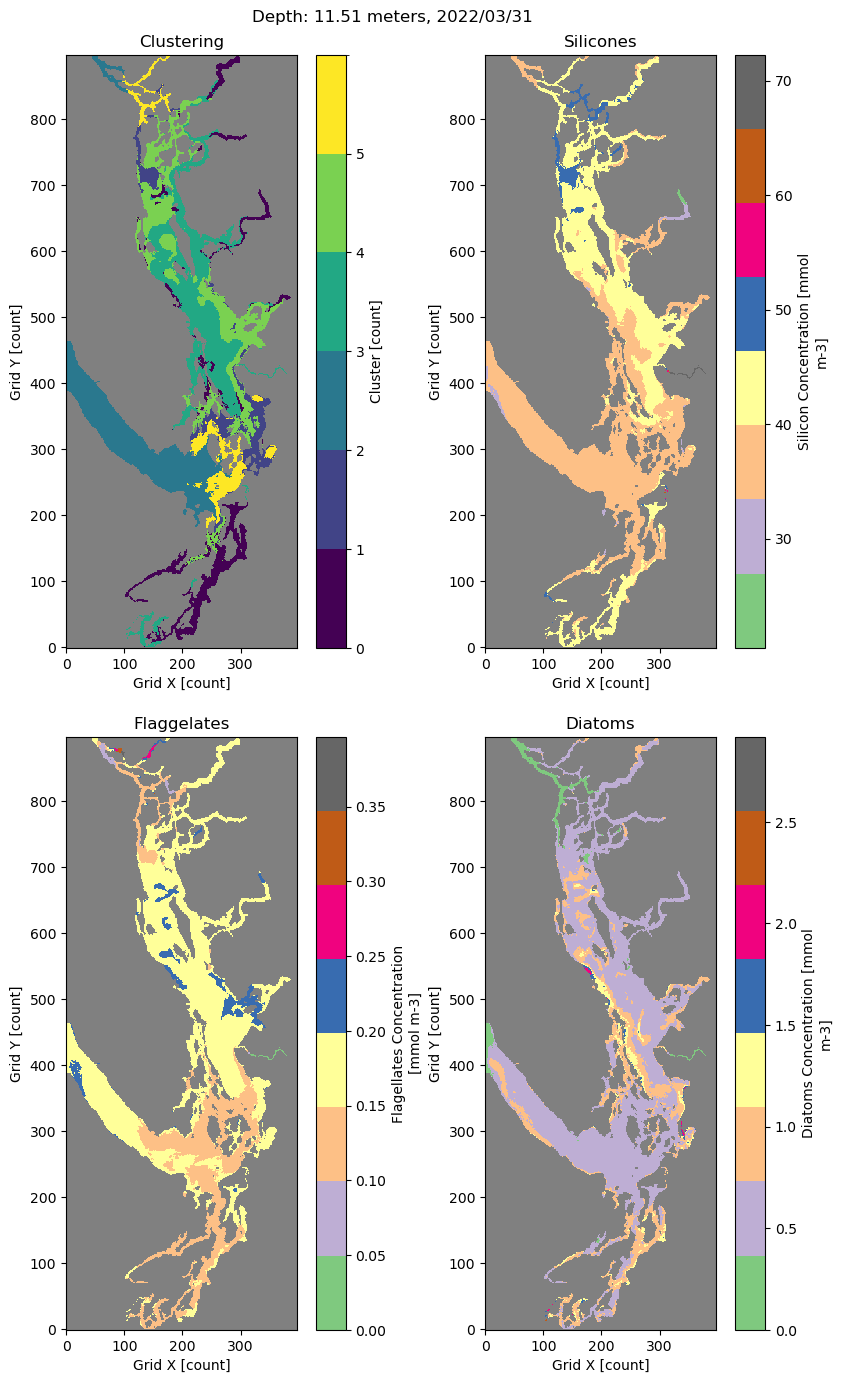

The amount of grid boxes for cluster 0 is 23355 

The minimum temperature for cluster 0 is 6.41 degrees Celsius
The maximum temperature for cluster 0 is 9.16 degrees Celsius
The mean temperature for cluster 0 is 7.97 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 28.83 g/kg
The mean salinity for cluster 0 is 28.27 g/kg 


The amount of grid boxes for cluster 1 is 15036 

The minimum temperature for cluster 1 is 7.68 degrees Celsius
The maximum temperature for cluster 1 is 8.53 degrees Celsius
The mean temperature for cluster 1 is 8.1 degrees Celsius 

The minimum salinity for cluster 1 is 28.79 g/kg
The maximum salinity for cluster 1 is 29.32 g/kg
The mean salinity for cluster 1 is 29.04 g/kg 


The amount of grid boxes for cluster 2 is 4930 

The minimum temperature for cluster 2 is 6.45 degrees Celsius
The maximum temperature for cluster 2 is 8.36 degrees Celsius
The mean temperature for cluster 2 is 7.87 degrees Celsius 

The m

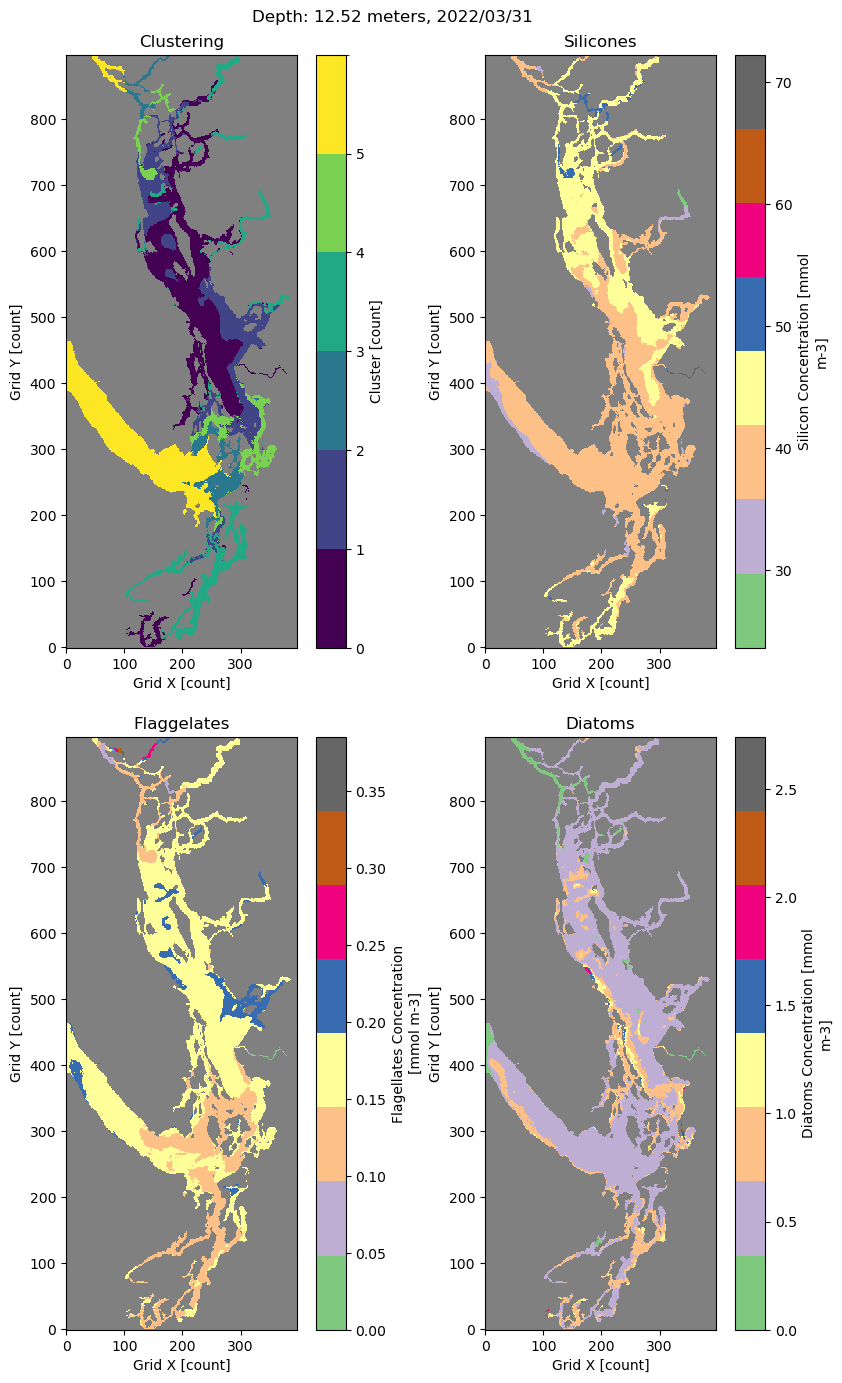

The amount of grid boxes for cluster 0 is 18232 

The minimum temperature for cluster 0 is 6.42 degrees Celsius
The maximum temperature for cluster 0 is 9.17 degrees Celsius
The mean temperature for cluster 0 is 7.97 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 28.78 g/kg
The mean salinity for cluster 0 is 28.27 g/kg 


The amount of grid boxes for cluster 1 is 17418 

The minimum temperature for cluster 1 is 7.63 degrees Celsius
The maximum temperature for cluster 1 is 8.49 degrees Celsius
The mean temperature for cluster 1 is 8.07 degrees Celsius 

The minimum salinity for cluster 1 is 28.76 g/kg
The maximum salinity for cluster 1 is 29.29 g/kg
The mean salinity for cluster 1 is 28.99 g/kg 


The amount of grid boxes for cluster 2 is 5427 

The minimum temperature for cluster 2 is 6.56 degrees Celsius
The maximum temperature for cluster 2 is 8.43 degrees Celsius
The mean temperature for cluster 2 is 7.87 degrees Celsius 

The 

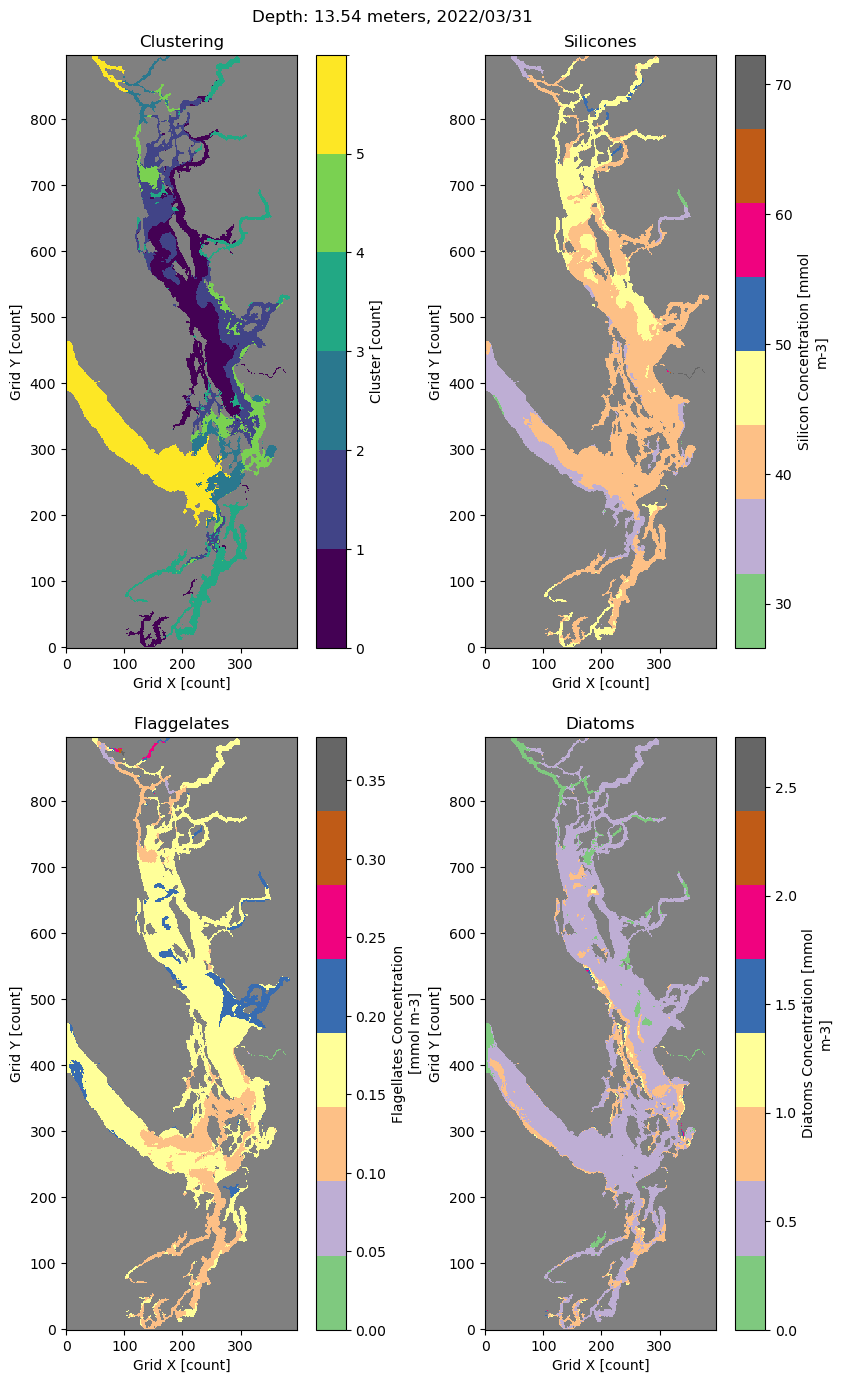

The amount of grid boxes for cluster 0 is 13277 

The minimum temperature for cluster 0 is 6.42 degrees Celsius
The maximum temperature for cluster 0 is 10.54 degrees Celsius
The mean temperature for cluster 0 is 8.65 degrees Celsius 

The minimum salinity for cluster 0 is 0.0 g/kg
The maximum salinity for cluster 0 is 29.43 g/kg
The mean salinity for cluster 0 is 28.35 g/kg 


The amount of grid boxes for cluster 1 is 12697 

The minimum temperature for cluster 1 is 7.83 degrees Celsius
The maximum temperature for cluster 1 is 10.19 degrees Celsius
The mean temperature for cluster 1 is 8.19 degrees Celsius 

The minimum salinity for cluster 1 is 29.01 g/kg
The maximum salinity for cluster 1 is 29.77 g/kg
The mean salinity for cluster 1 is 29.18 g/kg 


The amount of grid boxes for cluster 2 is 5098 

The minimum temperature for cluster 2 is 6.68 degrees Celsius
The maximum temperature for cluster 2 is 8.66 degrees Celsius
The mean temperature for cluster 2 is 7.88 degrees Celsius 

Th

The amount of grid boxes for cluster 0 is 13148 

The minimum temperature for cluster 0 is 8.12 degrees Celsius
The maximum temperature for cluster 0 is 10.53 degrees Celsius
The mean temperature for cluster 0 is 8.71 degrees Celsius 

The minimum salinity for cluster 0 is 20.07 g/kg
The maximum salinity for cluster 0 is 29.6 g/kg
The mean salinity for cluster 0 is 28.68 g/kg 


The amount of grid boxes for cluster 1 is 4303 

The minimum temperature for cluster 1 is 7.61 degrees Celsius
The maximum temperature for cluster 1 is 8.66 degrees Celsius
The mean temperature for cluster 1 is 7.99 degrees Celsius 

The minimum salinity for cluster 1 is 29.44 g/kg
The maximum salinity for cluster 1 is 29.95 g/kg
The mean salinity for cluster 1 is 29.65 g/kg 


The amount of grid boxes for cluster 2 is 15726 

The minimum temperature for cluster 2 is 7.2 degrees Celsius
The maximum temperature for cluster 2 is 8.26 degrees Celsius
The mean temperature for cluster 2 is 7.81 degrees Celsius 

The

The amount of grid boxes for cluster 0 is 11887 

The minimum temperature for cluster 0 is 8.1 degrees Celsius
The maximum temperature for cluster 0 is 10.21 degrees Celsius
The mean temperature for cluster 0 is 8.55 degrees Celsius 

The minimum salinity for cluster 0 is 22.81 g/kg
The maximum salinity for cluster 0 is 29.16 g/kg
The mean salinity for cluster 0 is 28.69 g/kg 


The amount of grid boxes for cluster 1 is 11725 

The minimum temperature for cluster 1 is 7.98 degrees Celsius
The maximum temperature for cluster 1 is 10.49 degrees Celsius
The mean temperature for cluster 1 is 8.43 degrees Celsius 

The minimum salinity for cluster 1 is 29.12 g/kg
The maximum salinity for cluster 1 is 29.8 g/kg
The mean salinity for cluster 1 is 29.27 g/kg 


The amount of grid boxes for cluster 2 is 4396 

The minimum temperature for cluster 2 is 6.93 degrees Celsius
The maximum temperature for cluster 2 is 8.66 degrees Celsius
The mean temperature for cluster 2 is 7.87 degrees Celsius 

Th

The amount of grid boxes for cluster 0 is 16191 

The minimum temperature for cluster 0 is 7.16 degrees Celsius
The maximum temperature for cluster 0 is 8.22 degrees Celsius
The mean temperature for cluster 0 is 7.79 degrees Celsius 

The minimum salinity for cluster 0 is 30.3 g/kg
The maximum salinity for cluster 0 is 31.89 g/kg
The mean salinity for cluster 0 is 30.97 g/kg 


The amount of grid boxes for cluster 1 is 5953 

The minimum temperature for cluster 1 is 7.57 degrees Celsius
The maximum temperature for cluster 1 is 8.4 degrees Celsius
The mean temperature for cluster 1 is 7.95 degrees Celsius 

The minimum salinity for cluster 1 is 29.13 g/kg
The maximum salinity for cluster 1 is 29.86 g/kg
The mean salinity for cluster 1 is 29.55 g/kg 


The amount of grid boxes for cluster 2 is 20092 

The minimum temperature for cluster 2 is 6.48 degrees Celsius
The maximum temperature for cluster 2 is 9.13 degrees Celsius
The mean temperature for cluster 2 is 7.97 degrees Celsius 

The 

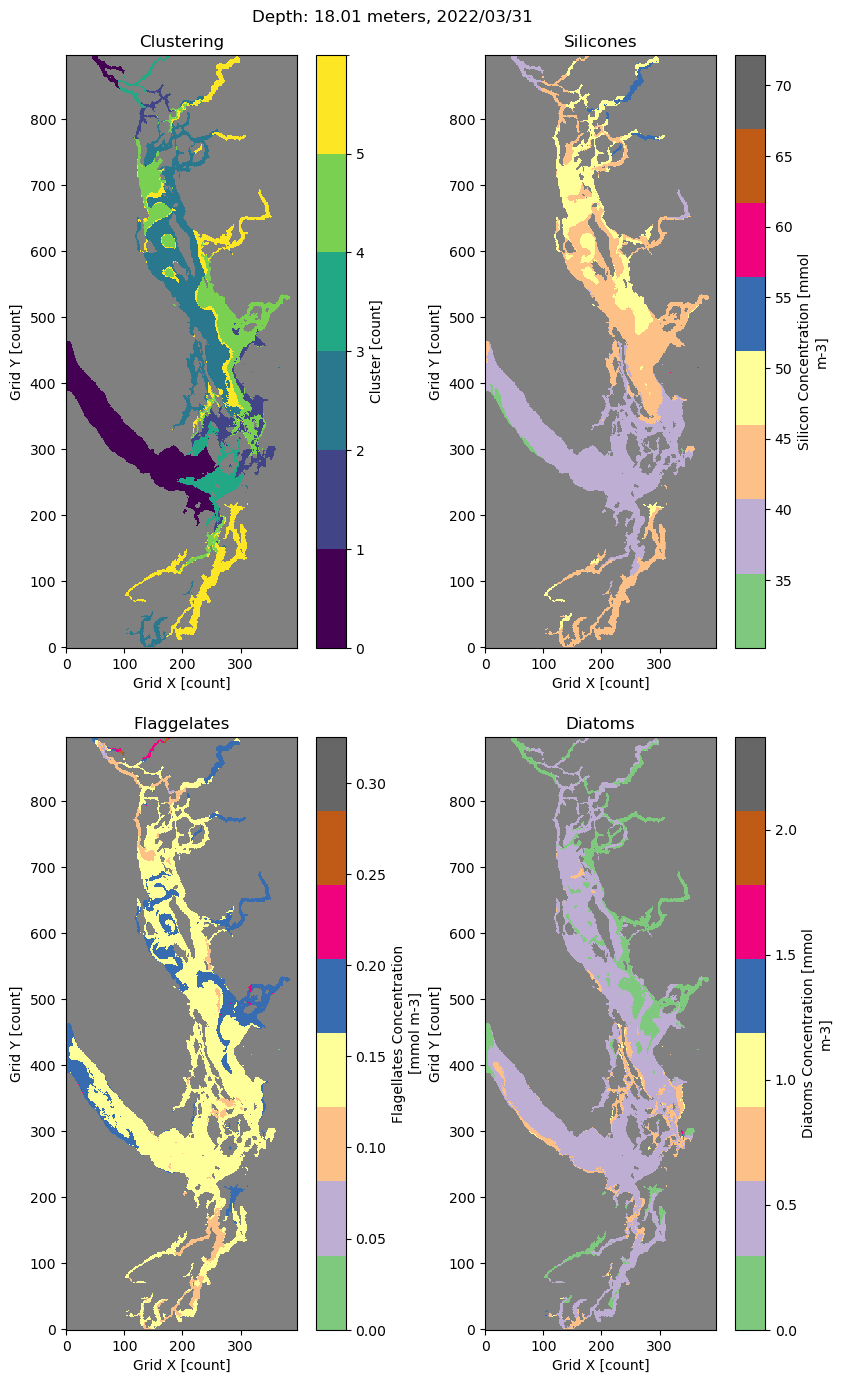

The amount of grid boxes for cluster 0 is 14820 

The minimum temperature for cluster 0 is 8.16 degrees Celsius
The maximum temperature for cluster 0 is 10.33 degrees Celsius
The mean temperature for cluster 0 is 8.7 degrees Celsius 

The minimum salinity for cluster 0 is 28.17 g/kg
The maximum salinity for cluster 0 is 29.76 g/kg
The mean salinity for cluster 0 is 29.2 g/kg 


The amount of grid boxes for cluster 1 is 3054 

The minimum temperature for cluster 1 is 7.61 degrees Celsius
The maximum temperature for cluster 1 is 8.67 degrees Celsius
The mean temperature for cluster 1 is 7.96 degrees Celsius 

The minimum salinity for cluster 1 is 29.53 g/kg
The maximum salinity for cluster 1 is 30.03 g/kg
The mean salinity for cluster 1 is 29.75 g/kg 


The amount of grid boxes for cluster 2 is 15203 

The minimum temperature for cluster 2 is 7.15 degrees Celsius
The maximum temperature for cluster 2 is 8.18 degrees Celsius
The mean temperature for cluster 2 is 7.77 degrees Celsius 

The

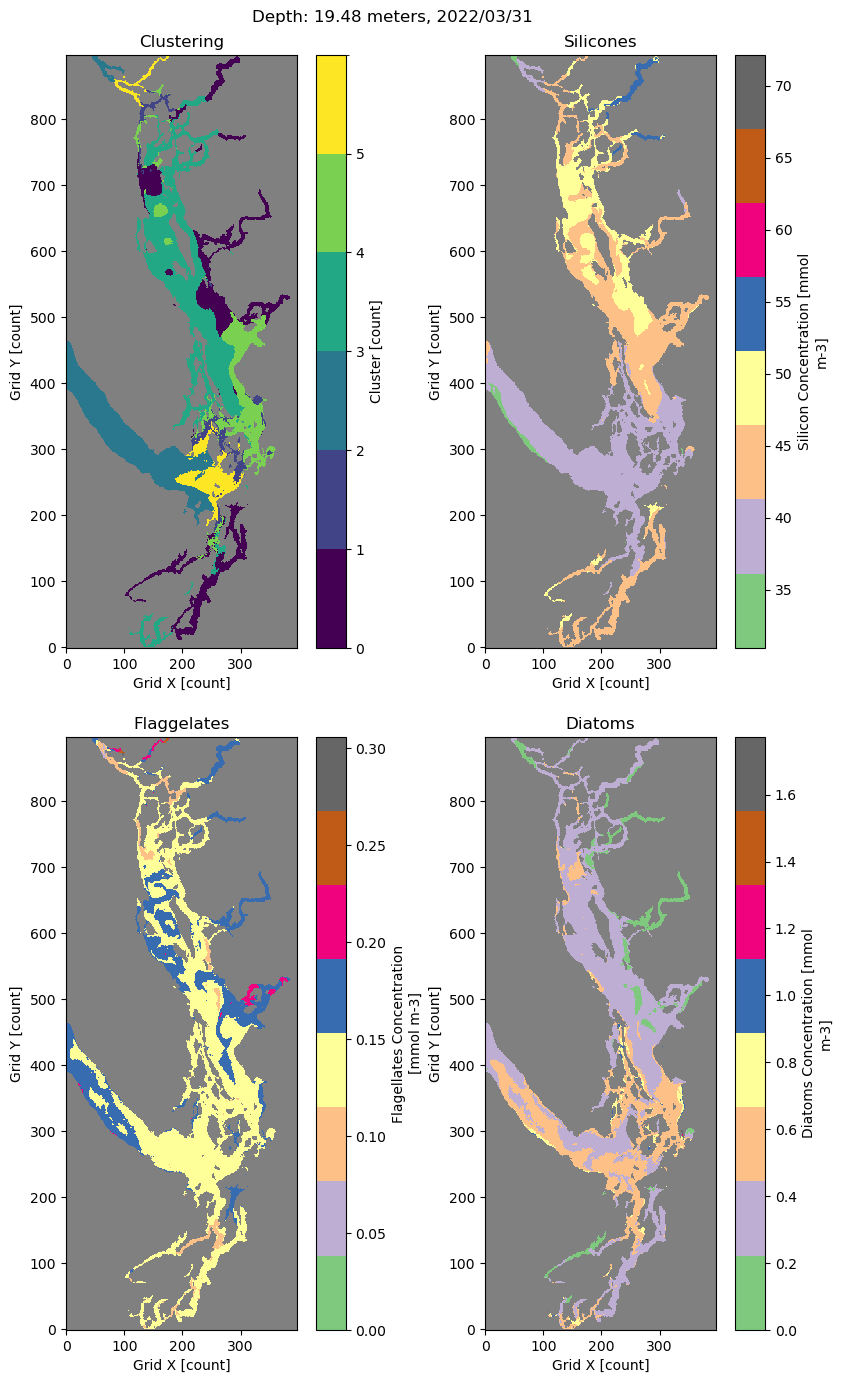

The amount of grid boxes for cluster 0 is 4680 

The minimum temperature for cluster 0 is 7.28 degrees Celsius
The maximum temperature for cluster 0 is 8.03 degrees Celsius
The mean temperature for cluster 0 is 7.82 degrees Celsius 

The minimum salinity for cluster 0 is 29.93 g/kg
The maximum salinity for cluster 0 is 30.61 g/kg
The mean salinity for cluster 0 is 30.31 g/kg 


The amount of grid boxes for cluster 1 is 11961 

The minimum temperature for cluster 1 is 7.59 degrees Celsius
The maximum temperature for cluster 1 is 8.43 degrees Celsius
The mean temperature for cluster 1 is 8.05 degrees Celsius 

The minimum salinity for cluster 1 is 29.16 g/kg
The maximum salinity for cluster 1 is 29.72 g/kg
The mean salinity for cluster 1 is 29.43 g/kg 


The amount of grid boxes for cluster 2 is 23474 

The minimum temperature for cluster 2 is 7.34 degrees Celsius
The maximum temperature for cluster 2 is 9.04 degrees Celsius
The mean temperature for cluster 2 is 8.03 degrees Celsius 

Th

The amount of grid boxes for cluster 0 is 20342 

The minimum temperature for cluster 0 is 7.34 degrees Celsius
The maximum temperature for cluster 0 is 8.81 degrees Celsius
The mean temperature for cluster 0 is 8.06 degrees Celsius 

The minimum salinity for cluster 0 is 26.4 g/kg
The maximum salinity for cluster 0 is 29.26 g/kg
The mean salinity for cluster 0 is 28.95 g/kg 


The amount of grid boxes for cluster 1 is 13889 

The minimum temperature for cluster 1 is 7.63 degrees Celsius
The maximum temperature for cluster 1 is 8.41 degrees Celsius
The mean temperature for cluster 1 is 8.06 degrees Celsius 

The minimum salinity for cluster 1 is 29.12 g/kg
The maximum salinity for cluster 1 is 29.7 g/kg
The mean salinity for cluster 1 is 29.43 g/kg 


The amount of grid boxes for cluster 2 is 4340 

The minimum temperature for cluster 2 is 7.28 degrees Celsius
The maximum temperature for cluster 2 is 8.04 degrees Celsius
The mean temperature for cluster 2 is 7.83 degrees Celsius 

The 

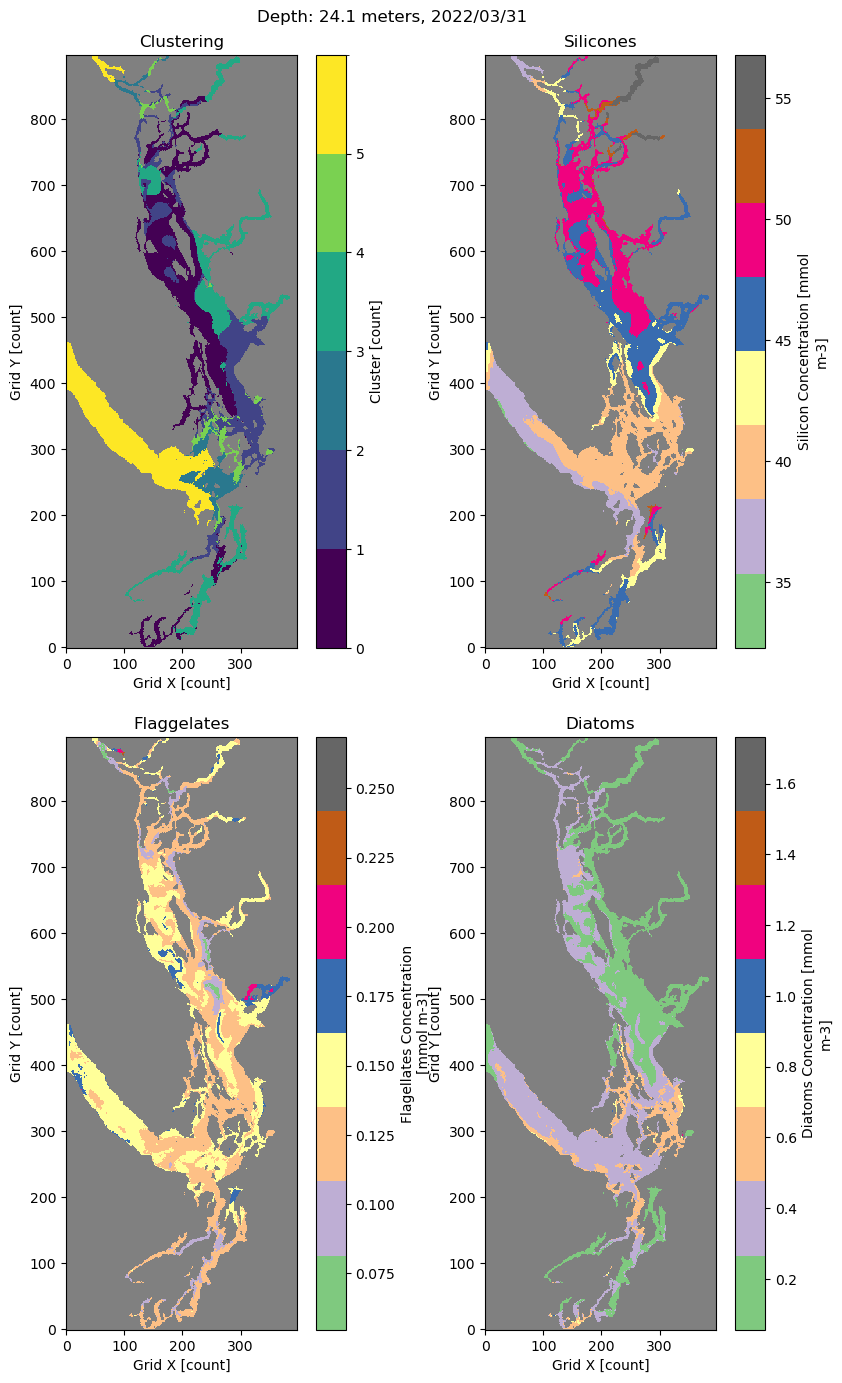

The amount of grid boxes for cluster 0 is 12386 

The minimum temperature for cluster 0 is 8.3 degrees Celsius
The maximum temperature for cluster 0 is 10.21 degrees Celsius
The mean temperature for cluster 0 is 8.83 degrees Celsius 

The minimum salinity for cluster 0 is 28.78 g/kg
The maximum salinity for cluster 0 is 29.97 g/kg
The mean salinity for cluster 0 is 29.53 g/kg 


The amount of grid boxes for cluster 1 is 1698 

The minimum temperature for cluster 1 is 7.65 degrees Celsius
The maximum temperature for cluster 1 is 8.69 degrees Celsius
The mean temperature for cluster 1 is 8.0 degrees Celsius 

The minimum salinity for cluster 1 is 29.71 g/kg
The maximum salinity for cluster 1 is 30.25 g/kg
The mean salinity for cluster 1 is 29.97 g/kg 


The amount of grid boxes for cluster 2 is 13628 

The minimum temperature for cluster 2 is 7.13 degrees Celsius
The maximum temperature for cluster 2 is 8.05 degrees Celsius
The mean temperature for cluster 2 is 7.69 degrees Celsius 

The

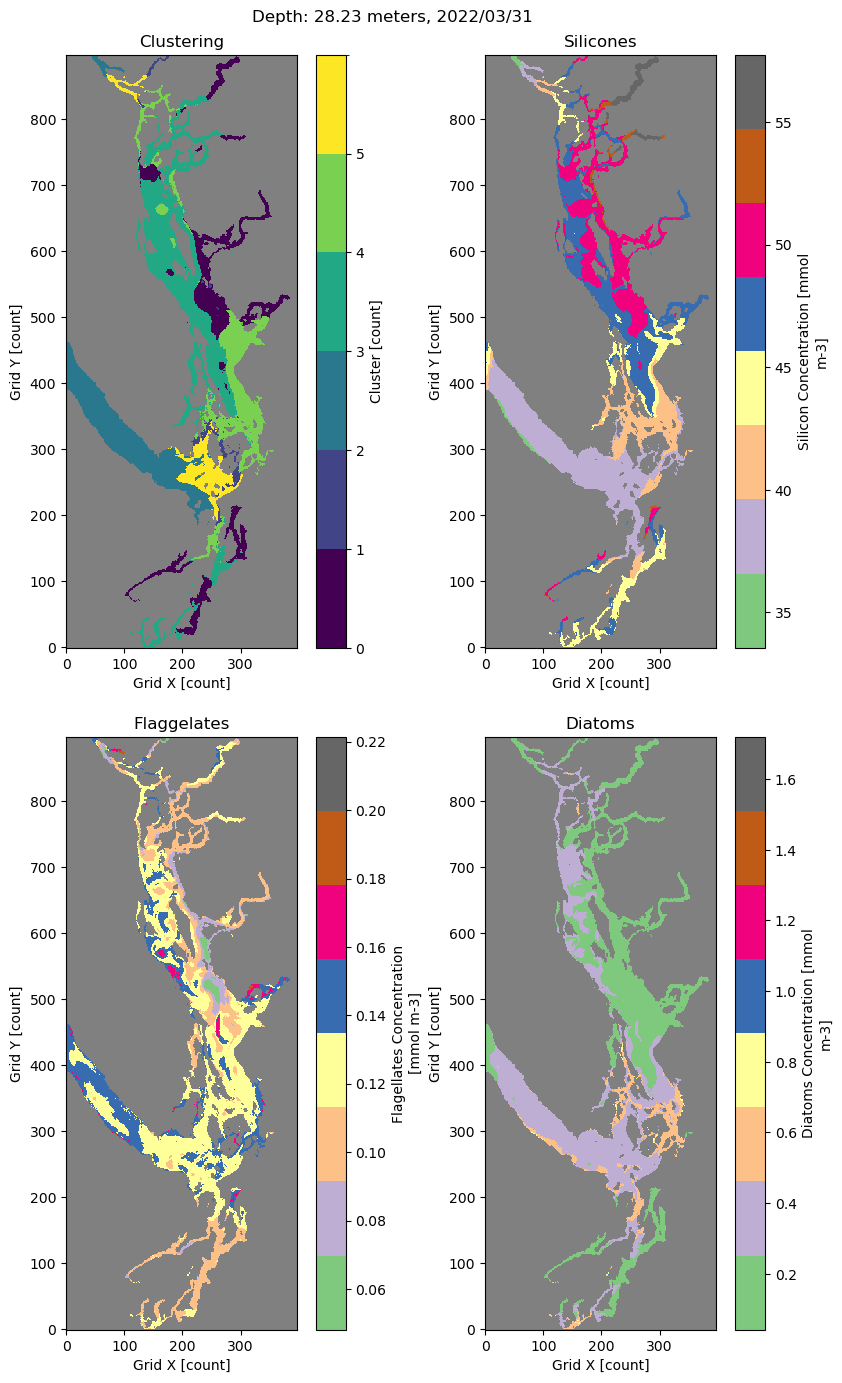

The amount of grid boxes for cluster 0 is 11802 

The minimum temperature for cluster 0 is 8.34 degrees Celsius
The maximum temperature for cluster 0 is 10.21 degrees Celsius
The mean temperature for cluster 0 is 8.85 degrees Celsius 

The minimum salinity for cluster 0 is 28.78 g/kg
The maximum salinity for cluster 0 is 30.02 g/kg
The mean salinity for cluster 0 is 29.7 g/kg 


The amount of grid boxes for cluster 1 is 903 

The minimum temperature for cluster 1 is 7.8 degrees Celsius
The maximum temperature for cluster 1 is 8.92 degrees Celsius
The mean temperature for cluster 1 is 8.07 degrees Celsius 

The minimum salinity for cluster 1 is 29.8 g/kg
The maximum salinity for cluster 1 is 30.33 g/kg
The mean salinity for cluster 1 is 30.05 g/kg 


The amount of grid boxes for cluster 2 is 14055 

The minimum temperature for cluster 2 is 7.13 degrees Celsius
The maximum temperature for cluster 2 is 7.9 degrees Celsius
The mean temperature for cluster 2 is 7.64 degrees Celsius 

The mi

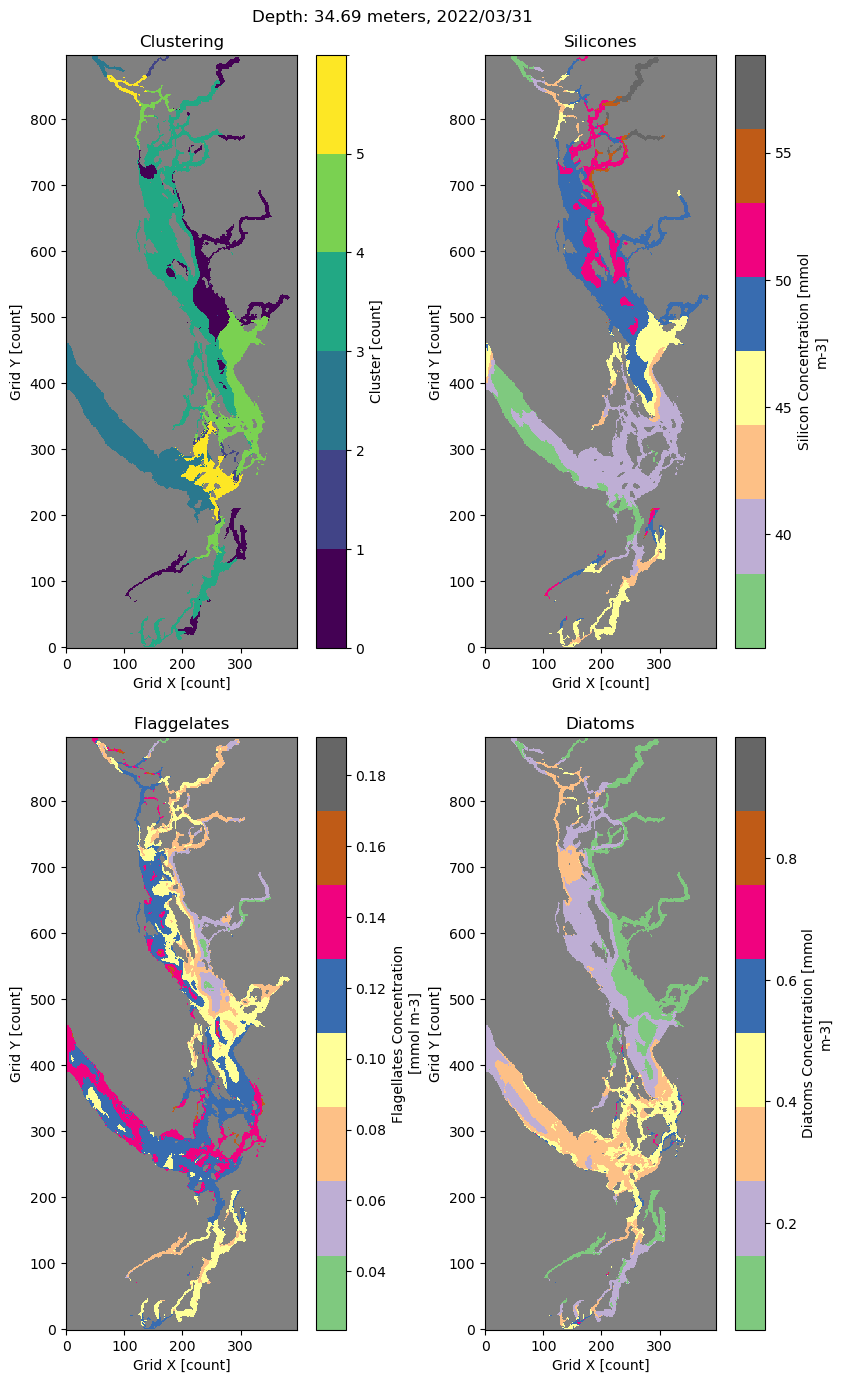

The amount of grid boxes for cluster 0 is 4604 

The minimum temperature for cluster 0 is 7.13 degrees Celsius
The maximum temperature for cluster 0 is 7.93 degrees Celsius
The mean temperature for cluster 0 is 7.72 degrees Celsius 

The minimum salinity for cluster 0 is 30.12 g/kg
The maximum salinity for cluster 0 is 31.0 g/kg
The mean salinity for cluster 0 is 30.68 g/kg 


The amount of grid boxes for cluster 1 is 10385 

The minimum temperature for cluster 1 is 7.34 degrees Celsius
The maximum temperature for cluster 1 is 8.39 degrees Celsius
The mean temperature for cluster 1 is 7.96 degrees Celsius 

The minimum salinity for cluster 1 is 29.42 g/kg
The maximum salinity for cluster 1 is 30.17 g/kg
The mean salinity for cluster 1 is 29.8 g/kg 


The amount of grid boxes for cluster 2 is 19764 

The minimum temperature for cluster 2 is 7.62 degrees Celsius
The maximum temperature for cluster 2 is 8.73 degrees Celsius
The mean temperature for cluster 2 is 8.29 degrees Celsius 

The 

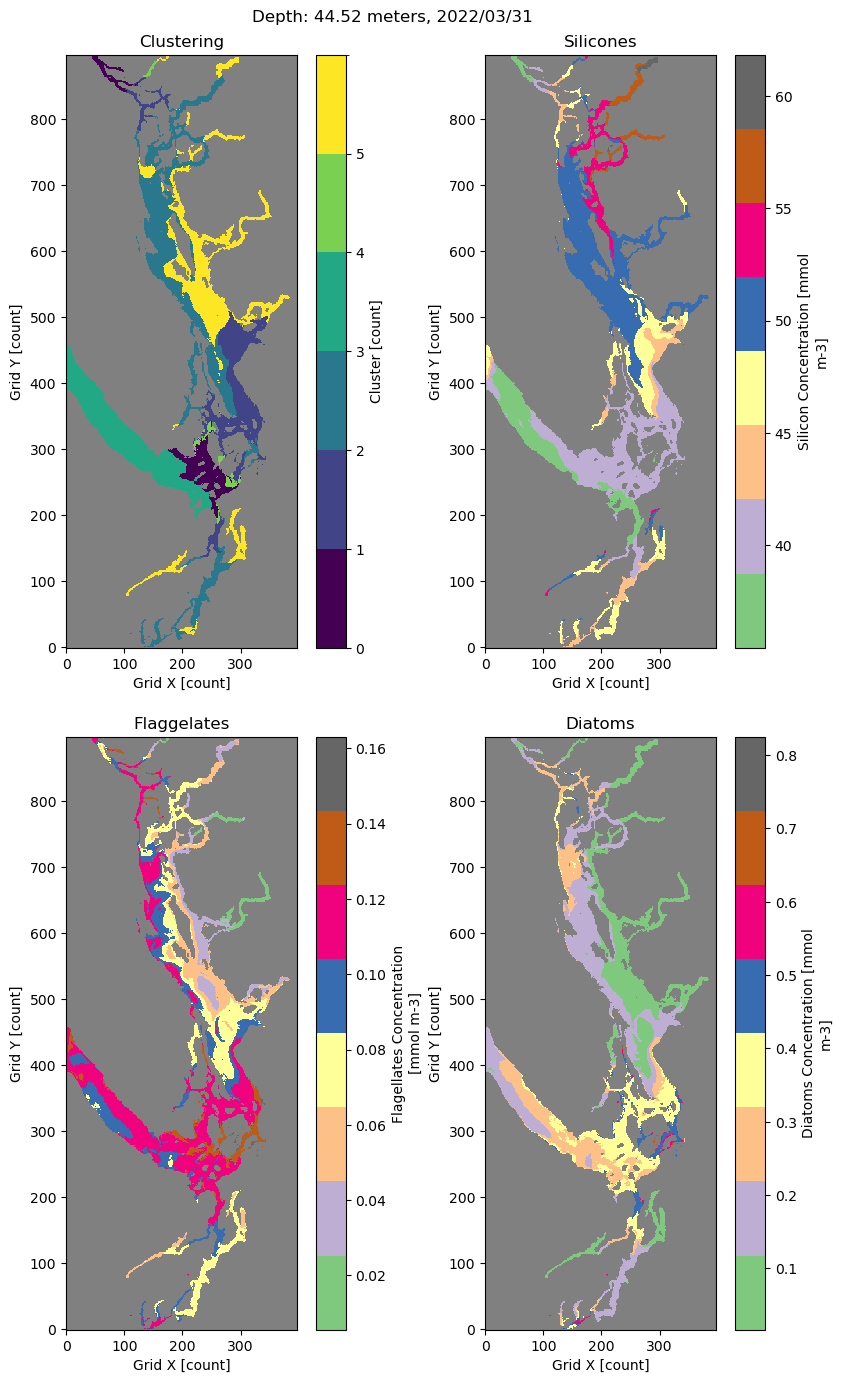

The amount of grid boxes for cluster 0 is 15603 

The minimum temperature for cluster 0 is 8.39 degrees Celsius
The maximum temperature for cluster 0 is 10.39 degrees Celsius
The mean temperature for cluster 0 is 8.83 degrees Celsius 

The minimum salinity for cluster 0 is 29.54 g/kg
The maximum salinity for cluster 0 is 30.47 g/kg
The mean salinity for cluster 0 is 29.95 g/kg 


The amount of grid boxes for cluster 1 is 834 

The minimum temperature for cluster 1 is 7.59 degrees Celsius
The maximum temperature for cluster 1 is 7.92 degrees Celsius
The mean temperature for cluster 1 is 7.76 degrees Celsius 

The minimum salinity for cluster 1 is 30.35 g/kg
The maximum salinity for cluster 1 is 30.7 g/kg
The mean salinity for cluster 1 is 30.5 g/kg 


The amount of grid boxes for cluster 2 is 11261 

The minimum temperature for cluster 2 is 7.29 degrees Celsius
The maximum temperature for cluster 2 is 7.67 degrees Celsius
The mean temperature for cluster 2 is 7.47 degrees Celsius 

The 

The amount of grid boxes for cluster 0 is 2856 

The minimum temperature for cluster 0 is 7.2 degrees Celsius
The maximum temperature for cluster 0 is 7.72 degrees Celsius
The mean temperature for cluster 0 is 7.58 degrees Celsius 

The minimum salinity for cluster 0 is 30.9 g/kg
The maximum salinity for cluster 0 is 31.79 g/kg
The mean salinity for cluster 0 is 31.39 g/kg 


The amount of grid boxes for cluster 1 is 7583 

The minimum temperature for cluster 1 is 7.43 degrees Celsius
The maximum temperature for cluster 1 is 8.33 degrees Celsius
The mean temperature for cluster 1 is 7.84 degrees Celsius 

The minimum salinity for cluster 1 is 29.79 g/kg
The maximum salinity for cluster 1 is 30.61 g/kg
The mean salinity for cluster 1 is 30.08 g/kg 


The amount of grid boxes for cluster 2 is 11342 

The minimum temperature for cluster 2 is 7.62 degrees Celsius
The maximum temperature for cluster 2 is 8.62 degrees Celsius
The mean temperature for cluster 2 is 8.2 degrees Celsius 

The mi

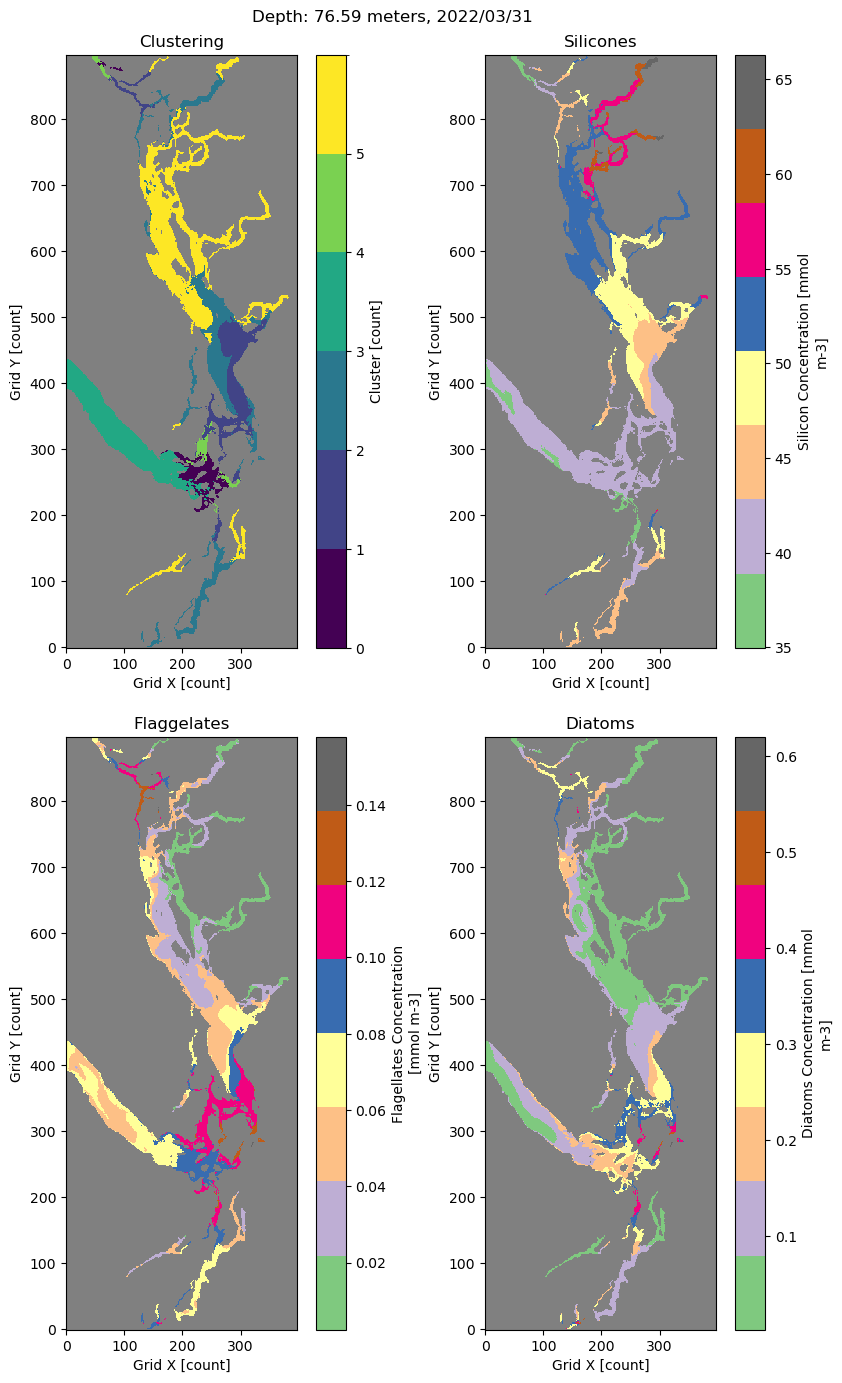

The amount of grid boxes for cluster 0 is 16697 

The minimum temperature for cluster 0 is 8.49 degrees Celsius
The maximum temperature for cluster 0 is 10.48 degrees Celsius
The mean temperature for cluster 0 is 8.91 degrees Celsius 

The minimum salinity for cluster 0 is 29.5 g/kg
The maximum salinity for cluster 0 is 30.57 g/kg
The mean salinity for cluster 0 is 30.2 g/kg 


The amount of grid boxes for cluster 1 is 297 

The minimum temperature for cluster 1 is 7.58 degrees Celsius
The maximum temperature for cluster 1 is 7.7 degrees Celsius
The mean temperature for cluster 1 is 7.65 degrees Celsius 

The minimum salinity for cluster 1 is 30.99 g/kg
The maximum salinity for cluster 1 is 31.23 g/kg
The mean salinity for cluster 1 is 31.1 g/kg 


The amount of grid boxes for cluster 2 is 8463 

The minimum temperature for cluster 2 is 7.07 degrees Celsius
The maximum temperature for cluster 2 is 7.5 degrees Celsius
The mean temperature for cluster 2 is 7.22 degrees Celsius 

The mini

The amount of grid boxes for cluster 0 is 1261 

The minimum temperature for cluster 0 is 7.29 degrees Celsius
The maximum temperature for cluster 0 is 7.7 degrees Celsius
The mean temperature for cluster 0 is 7.64 degrees Celsius 

The minimum salinity for cluster 0 is 30.64 g/kg
The maximum salinity for cluster 0 is 31.69 g/kg
The mean salinity for cluster 0 is 31.0 g/kg 


The amount of grid boxes for cluster 1 is 13062 

The minimum temperature for cluster 1 is 7.41 degrees Celsius
The maximum temperature for cluster 1 is 8.21 degrees Celsius
The mean temperature for cluster 1 is 7.92 degrees Celsius 

The minimum salinity for cluster 1 is 29.06 g/kg
The maximum salinity for cluster 1 is 30.68 g/kg
The mean salinity for cluster 1 is 30.19 g/kg 


The amount of grid boxes for cluster 2 is 3845 

The minimum temperature for cluster 2 is 8.17 degrees Celsius
The maximum temperature for cluster 2 is 8.76 degrees Celsius
The mean temperature for cluster 2 is 8.43 degrees Celsius 

The m

IndexError: index 5 is out of bounds for axis 0 with size 5

In [21]:
ds, temp, saline, date, mask, sil, flag, diat = datasets_preparation()

for depth in range (0, ds['deptht'].size+1):

    temp, saline, sil, flag, diat = masking(depth, temp, saline, mask, sil, flag, diat)
    unique, counts, inputs, predictions, clusters = som(depth, temp, saline)
    printing(inputs, predictions, unique, counts)
    plotting (depth, clusters, unique, sil, flag, diat)
